# Проект для сервиса автоматизации управления строительством

<font size="4"><b>О проекте:</b></font>

Заказчик - это облачный сервис для автоматизации управления строительством и ремонтом.
Компания продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.
Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.

***Цель проекта:*** *предложить возможные способы снижения оттока клиентов банка.*

***Задачи:***
1. *Провести исследовательский анализ данных*
2. *Составить портреты наиболее типичных клиентов*
3. *Определить возможные причины оттока клиентов*
4. *Предложить решения для минимизации оттока*

<font size="4"><b>Описание данных:</b></font>

Данные представлены 4-мя датасетами.

* **activities** - количество совершенных компанией действий по месяцам:
    - `Company_id` - идентификатор компании;
    - `Month` - отчетный месяц;
    - `Company-month-billing` - количество счетов, выставленных в приложении, компанией за месяц;
    - `Company-month-stocks` - месячное количество складов (аренда, заказы и т.д.), используемых компанией;
    - `Company-month-backups` - месячное количество бэкапов компании;
    - `Company-month-projects` - месячное количество проектов компании;
    - `Company-month-contractors` - месячное количество контрагентов компании;
    - `Company-month-resource_orders` - месячное количество заказов материалов компании.
    
    
* **billing** - информация о платежах (и оформленных подписках):
    - `User_id` - идентификатор пользователя;
    - `Company_id` - идентификатор компании пользователя;
    - `Billing_tariff_id` - тарифный план;
    - `Payed_until` - дата, до которой подписка компании действует;
    - `Is_payed` - статус оплаты;
    - `Created_at` - дата создания;
    - `Updated_at` - дата обновления;
    - `Billing_tariff_price_id` - id стоимости тарифа;
    - `Comment` - комментарии;
    - `Pay_date` - дата платежа.
    
*Примечания: тарифы 1, 18, 22 - тестовые, бесплатные и пробные; тарифы 4, 7, 8, 11, 19 - группа “старт”, тарифы 2, 17 - группа “базовый”, тарифы 9, 20 - группа “бизнес”, тарифы 3, 10, 13, 21 - группа “Профи”, тариф 6 - “архивный”, в настоящее время не используется.*

*Кроме того, в разное время или для разных клиентов  один и тот же тариф может стоить по-разному.*



* **companies** - информация о клиентах сервиса (компаниях, оформлявших подписки):
    - `Id` - id компании;
    - `Working_direction` - сфера деятельности;
    - `Employer_count_interval` - id количества сотрудников (d от 1 до 8, количество сотрудников - (1-4, 5-10, 11-20, 21-30, 31-50, 51-100, 101-200, >201));
    - `Created_at` - дата создания компании в системе;
    - `Updated_at` - дата обновления информации о компании;
    - `Billing_tariff_id` - id тарифа;
    - `Billing_is_over` - истекла ли оплата.
    

* **people** - информация о сотрудниках компании:
    - `Id` - индекс;
    - `Company_id` - id компании;
    - `User_id` - id пользователя;
    - `Role_id` - id роли (должности);
    - `Created_at` - дата создания пользователя;
    - `Updated_at` - дата обновления информации о пользователе;
    - `Is_deleted` - удален ли пользователь;
    - `Deleted_at` - дата удаления.





## Общая информация о датасете

### Загрузка данных

In [1]:
# импортируем все необходимые библиотеки

import re
import math as mth
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from plotly import graph_objects as go


In [2]:
# добавь полный путь к папке с датасетами
path = r'your_total_path'

In [3]:
# загрузка данных

activities_raw = pd.read_csv(r'activities.csv')
billing_raw = pd.read_csv(r'billing.csv')
companies_raw = pd.read_csv(r'companies.csv')
people_raw = pd.read_csv(r'people.csv')


In [4]:
activities_raw.name = 'activities_raw'
billing_raw.name = 'billing_raw'
companies_raw.name = 'companies_raw'
people_raw.name = 'people_raw'

### Определение функций

#### `df_info()`

In [5]:
# введём функцию, позволяющую вывести общую информацию о данных

def df_info(df, figsize=(14, 10)):
    
    """Вывод общей информации о данных

    df - датасет,
    figsize - размер гистограмм
    """
    
    print('Вид данных:')
    display(df.head())
    
    print()
    print('Общая информация о данных:')
    print()
    df.info()
    
    # Создадим список булева типа, чтобы выбрать неподходящие поля
    cond = []
    for col in df.columns:
        if 'id' in col or 'Id' in col:
            cond.append(False)
        else:
            cond.append(True)
    
    # Построим гистограммы для тех числовых полей, которые не являются идентификаторами, если такие есть в датасете
    if len(df.loc[:, cond].select_dtypes(include=['int64', 'float64']).columns) != 0:
        print()
        print('Распределения числовых величин в данных:')
        df.loc[:, cond].hist(figsize=figsize, color='SteelBlue', grid=False, bins=60)
    plt.show()

#### `to_datetime()`

In [6]:
# функция преобразования данных о времени

def to_datetime(df, cols, date=False, both=False, second_name=''):
    
    """Преобразование типа данных нескольких столбцов датасета к типу datetime или date (заменяет тип исходного столбца)
    
    df - датасет,
    cols - список с названиями столбцов, в которых нужно изменить тип
    date (False) - если True, отсекает временную часть и оставляет только дату
    both (False) - если True, то изменяет тип текущего столбца на datetime, дополнительно создаёт столбец с именем second_name, 
                   в котором будет хранится только дата
    second_name (пустая строка) - параметр принимает строку, при both=True задаёт имя для нового столбца с датой
    
    """
    
    if date:
        for col in cols:
            df[col] = pd.to_datetime(df[col], unit='s').dt.date
    elif both:
        for col in cols:
            df[second_name] = pd.to_datetime(df[col], unit='s').dt.date
            df[col] = pd.to_datetime(df[col], unit='s')
    else:
        for col in cols:
            df[col] = pd.to_datetime(df[col], unit='s')
            

#### `add_labels()`

In [7]:
# добавление числовых значений на графиках-рейтингах (типа barh)
def add_labels(x, y, score=1, inter=0, percent=False, color='white'):
    
    """Функция добавляет подписи значений для графиков типа barh.
    
    Принимаемые параметры:
    х - названия категорий
    у - список значений параметра для каждой категории
    score - число для корректировки положения надписи относительно длины столбца: score умножается на значение параметра,
            например, если длина столбца - 20, a score=1/2, то подпись к этому столбцу будет расположена посередине столбца
    inter - число для корректировки положения надписи относительно длины столбца: добавляет к положению, определенному
            с помощью score сдвиг по оси Ох
    percent - когда True: добавляет значение доли данной категории относительно всех изображенных на графике,
              например, если всего 2 категории cat1 = 700, cat2=300, то подпишет, что доля cat1 = 70%, а доля cat2=30%
    color - цвет подписи значения столбца, не влияет на цвет подписи доли катигории (цвет доли всегда чёрный)
    """
    # для каждой категории 
    for i in range(len(x)):
        plt.text(
            y[i] * score + inter, # положение по оси Ох
            i,                    # положение по оси Оу 
            y[i],                 # отображаемое значение (значение столбца)
            ha = 'center', size=12, va='center', color=color, fontweight='bold' # форматирование выводимого текста
        )
        
        # выводим, если нужны доли категории относительно всех выведенных на графике
        if percent:
            plt.text(y[i] + y.max()/10, i, f'{round(y[i] / y.sum() * 100, 2)}%', 
                     ha = 'center', size=10, va='center', color='black')

#### `pass_value_barh()`

In [8]:
# посмотрим долю пропущенных значений в столбцах
def pass_value_barh(df):
    
    """Функция выводит долю пропущенных значений по столбцам.
    
    Принимаемые параметры:
    df - исследуемый датасет
    """
    
    # выделим пространство под график
    fig = plt.figure(figsize=(5,2))
    fig.suptitle('Доля пропусков в столбцах' + "\n", fontsize=12)
    fig.add_subplot(111)
    
    # группируем информацию
    df = (
        (df.isna().mean()*100)              # даёт долю пропущенных значений от всего датасета
        .to_frame()                         # чтобы работать как с DataFrame
        .rename(columns = {0:'ratio'})
        .query('ratio > 0')                 # рассмотрим только столбцы с пропущенными значениями
        .sort_values(by = 'ratio', ascending = True)
    )
    
    # построим график
    (
        plt
        .barh( 
            y=df.index,
            width=df['ratio'],
            color='SteelBlue',
            height=0.5
        )
    )
    
    # редактируем подписи
    plt.xlabel('Доля в столбце, %', fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    plt.show()
    
    #add_labels(df.index, df['ratio'], score=1, inter=1, color='black')

#### `percentils()`

In [9]:
# функция для расчета интересующих перцентилей
def percentils(data, col, perc=[90, 95, 99]):
    """Расчет перцентилей по столбцу датасета.
    
    data - датасет,
    col - (строка) название столбца, по которому производить расчет
    perc ([90, 95, 99]) - (список int) список перцентилей, которые необходимо рассчитать
    
    """
    
    percs = np.percentile(data[col], perc)
    
    for i in range(len(perc)):
        print(f"{perc[i]}-й перцентиль: {percs[i]:.2f}")

#### `clean_activities()`

In [10]:
def clean_activities(df):
    
    # подсчитаем количество действий разного типа на компанию
    table = (
            df
            .groupby('company_id')
            .agg({
                **dict.fromkeys(
                    [x for x in activities.columns if x not in ['month', 'company_id']], 'median'
                )
            })
            .reset_index()
        )
    
    # отберем те, что не выходят за 99-й процентиль
    table = table[(table['billing'] < 3) & (table['stocks'] < 40) &\
                 (table['backups'] < 11) & (table['projects'] < 35) & (table['contractors'] < 60) &\
                 (table['resource_orders'] < 80)]
    
    # выделим список оставшихся компаний
    cids = table['company_id']
    
    df = df[df['company_id'].isin(cids)]

#### `work_group()`

In [11]:
# функция для группировки значений о направлении деятельности компании

def work_group(st):

    try:
        if 'ремонт' in st:
            return 'Строительно-ремонтная компания'
        elif 'малоэтаж' in st or 'дом' in st or 'котте' in st or 'здан' in st or 'недвиж' in st:
            return 'Строительство объектов недвижимости'
        elif 'монтаж' in st:
            return 'Строительно-монтажные работы'
        elif 'отдел' in st:
            return 'Отделочные работы'
        elif 'энерг' in st:
            return 'Энергетика'
        elif 'строит' in st:
            return 'Строительство'
        else:
            return 'Другое'
        
    except:
        return 'Не указано'
    


#### `count_delays()`

In [12]:
def count_delays(activities):
    
    # создаем таблицу с подсчетом разницы дней активными месяцами
    no_activity_delay = (
        activities
        .sort_values(by=['company_id', 'month'])
        .reset_index(drop=True)
    )
    no_activity_delay
    no_activity_delay['previous_month'] = no_activity_delay.groupby('company_id').month.shift(1)
    no_activity_delay['delay'] = (no_activity_delay['month'] - no_activity_delay['previous_month'])
    
    # отобразим разброс значений
    no_activity_delay['delay_in_months'] = no_activity_delay['delay'] / np.timedelta64(1, 'M')
    print('Посмотрим на разброс значений для разных расчетов:')
    display(
        (
            no_activity_delay
            .pivot_table(
                index='company_id',
                values='delay_in_months',
                aggfunc=['mean', 'median', 'max']
            )
        )
        .droplevel(1, axis=1)
        .rename(columns={
            'mean' : 'mean_delay_per_company',
            'median' : 'median_delay_per_company',
            'max' : 'max_delay_per_company'
        })
        .describe()
    )
    
    # создадим столбец с медианным значением перерыва для каждой компании    
    delays = (
        no_activity_delay
        .dropna()
        .groupby('company_id')
        .agg({
            'delay_in_months' : 'median'
        })
        .round()
        .reset_index()
    )
    
    activities['median_delay_in_months'] = 0
    for cid in delays.company_id.unique():
        activities.loc[activities['company_id'] == cid, 'median_delay_in_months'] = \
        delays.loc[delays['company_id'] == cid, 'delay_in_months'].squeeze()


#### `get_dum()`

In [13]:
# функция для кодировки категориальных переменных
def get_dum(df, col):
    
    """Функция для кодировки категориальных переменных
    
    Принимаемые параметры:
    df - исследуемый датасет
    col - столбец датасета, значения которого надо закодировать
    """
    
    dummed = df[col]
    dummed = pd.get_dummies(df, columns=[col])
    dummed = dummed.loc[:, dummed.columns.str.find(col) != -1]
    
    return dummed

#### `bar_plot()`

In [14]:
def bar_plot(df, x, y, hue, est=np.median, title='', figsize=(9, 5), color=None):
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine(left=False, ax=ax)
    
    if color == None:
        sns.barplot(
            x=x, y=y, hue=hue, data=df, 
            estimator=est, #ci=None, 
            ax=ax, palette = sns.color_palette('Set2')
        )
    else:
        sns.barplot(
            x=x, y=y, hue=hue, data=df, 
            estimator=est, #ci=None, 
            ax=ax, color = color
        )
        
    plt.title(title + '\n', fontsize=16)
    plt.xticks(fontsize=12)
    if hue != None:
        plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=12, title=hue)
    

#### `fig_barh()`

In [15]:
# для построения графиков рейтингов
def fig_barh(title,  font_title, figsize, categories, values, xlabel, score=1, text=False, percent=False):

    sns.set(style="white")

    fig = plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=font_title)
    fig.add_subplot(111)

    (
        plt
        .barh(categories,
              values,
              color='SteelBlue')
    );

    plt.xlabel(xlabel, fontsize=12);
    plt.yticks(fontsize=10);
    plt.xticks(fontsize=10);
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    if text:
        add_labels(categories, values, score, percent=percent)
        

#### `new_companies_graph()`

In [16]:
def new_companies_graph():
    
    fig = (
        px
        .line(
            (
                billing
                .groupby('company_id')
                .agg({'created_at' : 'min'})
                .astype("datetime64[M]")
                .reset_index()
                .groupby('created_at')
                .agg({'company_id' : 'count'})
                .reset_index()
                .rename(columns={'company_id' : 'count_of_new_companies'})
            ),
        
            x = 'created_at',
            y = 'count_of_new_companies',
        

            title = 'Количество новых компаний в месяц',
            template="simple_white"
        )
        .update_layout(xaxis_title="Date", yaxis_title="Количество компаний")
    )

    fig.show()


#### `ratio_per_category()`

In [17]:
def ratio_per_category(df, cat, col='is_default', index='company_id', gr1='ушедшие', gr2='остающиеся', 
                       title_part='', figsize = (13, 5), rot=0):
    
    # пространство для графика
    fig, ax = plt.subplots(figsize = figsize)
    
    # порядок на диаграмме и агрегация данных
    r = range(len(df[cat].unique()))
    df_grouped = df.groupby([cat, col])[index].agg('count')
    raw = {gr1 : df_grouped[:, 1], gr2 : df_grouped[:, 0]}
    df = pd.DataFrame(raw).fillna(0)
    
    # группы для диаграммы с подсчетом доли
    totals = [i+j for i, j in zip(df[gr1], df[gr2])]
    churn_uids = [i/j*100 for i, j in zip(df[gr1], totals)]
    with_us = [i/j*100 for i, j in zip(df[gr2], totals)]
    
    # толщина колонок и названия групп
    barWidth = 0.85
    names = df.index
    
    # первые колонки для оставшихся
    plt.bar(r, with_us, color=sns.color_palette('Set2')[0], edgecolor='white', width=barWidth, label=gr2)
    for i in range(len(with_us)):
        plt.text(i, with_us[i] // 2, f'{round(with_us[i])}%', ha='center', va='center', size=9, fontweight='bold')
        
    # вторые колонки для ушедших
    plt.bar(r, churn_uids, bottom=with_us, color=sns.color_palette('Set2')[1], edgecolor='white', width=barWidth, label=gr1)
    for i in range(len(churn_uids)):
        plt.text(i, with_us[i] + churn_uids[i] // 2, f'{round(churn_uids[i])}%', ha='center', va='center', size=9, fontweight='bold')
        
     # подписи на оси х
    plt.xticks(r, names)

    # добавление легенды
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=10)
 
    # подписи и вывод графика
    plt.title(f'Доля ушедших компаний' + title_part + '\n', fontsize=14)
    plt.ylabel('Доля от всех компаний группы, %', fontsize=12)
    plt.xlabel(cat, fontsize=10)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=10, rotation=rot)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.set_ylim(0, 100)
    plt.tight_layout()
    plt.show()


#### `role_for_csize_plot()`

In [18]:
def role_for_csize_plot(data, csize, width=.85, title='Распределение кол-ва заведений по категориям'):

    # пространство для графика
    fig, ax = plt.subplots(figsize = (13, 8))
    ax.set_facecolor('white')

    # порядок на диаграмме (позиция Ох)
    r = range(len(data[csize].unique()))
    # порядок в столбцах по категориям
    order_cat = data.groupby('role_id')['id'].agg('count').sort_values(ascending=False).index
    # порядок столбцов
    order_reg = data.groupby(csize)['id'].agg('count').sort_values(ascending=False).index

    # набираем значения для каждой группы
    bars = []
    data_grouped = data.groupby([csize, 'role_id'])['id'].agg('count')
    data_grouped = data_grouped.to_frame()

    # проверим, что для каждого региона представлены все категории
    # если какой-либо категории нет, добавим её в фрейм, указав число заведений равным 0
    for reg in order_reg:
        for cat in order_cat:
            if cat not in data_grouped.loc[reg].index:
                data_grouped.loc[(reg, cat), 'id'] = 0

    # добавим столбец для расчета доли
    data_grouped['ratio'] = 0

    # для каждого региона найдём общее количество завелений и долю заведений каждой категории внутри региона
    total = []
    for i in range(len(order_reg)):
        total.append(data_grouped.loc[order_reg[i]]['id'].sum())
        for cat in order_cat:
            data_grouped.loc[(order_reg[i], cat), 'ratio'] = data_grouped.loc[(order_reg[i], cat), 'id'] / total[i] * 100

    # соберем списки для построения столбцов каждой категории для каждого региона
    for cat in order_cat:
        count_for_reg = []
        for reg in order_reg:
            count_for_reg.append(data_grouped.loc[(reg, cat), 'ratio'])
        bars.append(count_for_reg)

    # столбцов ширина
    bar_width = width

    # для каждой категории строим значения вдоль фигуры по регионам
    bottom = [0] * len(order_reg)
    for i in range(len(bars)):
        plt.bar(r, bars[i], bottom=bottom, color=sns.color_palette("tab20c", 25)[i], edgecolor='white',
                width=bar_width, label=order_cat[i])
        # обновим начало отсчета для следующей категории
        for j in range(len(bottom)):
            bottom[j] += bars[i][j]

    # добавим общее кол-во заведений для каждого региона на график
    for i in r:
        plt.text(i, 50, f'Количество сотрудников в топе: {round(total[i])}', ha='center', va='center',
                 size=14, fontweight='bold', rotation=90, color='white')

    plt.xticks(r, order_reg, fontweight='bold', rotation=80)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=14, title='id роли')
    plt.ylabel('Доля от количества сотрудников из \n ТОР-3 ролей для группы компаний, %')
    plt.xlabel('Код размера компании')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.title(title, fontsize=20);

#### `plot_pie()`

In [19]:
def plot_pie(df, col, ind='id', title='', labels=None):
    
    if labels == None:
        (
            df
            .groupby(col)
            .agg('count')[ind]
            .sort_values()
            .plot(
                kind='pie', 
                colors = sns.color_palette('Set2'),
                ylabel='',
                autopct='%1.0f%%',
                textprops={'fontsize':12},
                title=title
            )
        )
    else:
        (
            df
            .groupby(col)
            .agg('count')[ind]
            .sort_values()
            .plot(
                kind='pie', 
                colors = sns.color_palette('Set2'),
                ylabel='',
                autopct='%1.0f%%',
                textprops={'fontsize':12},
                labels=labels,
                title=title
            )
        )

#### `matr_corr()`

In [20]:
# построение корреляционных матриц
def matr_corr(df, colls, title, annot=True, figsize=(7, 7), cols_show=None, pal='icefire'):
    
    # если отображаемые столбцы отдельно не выбраны, то рисуем все
    if cols_show == None:
        cols_show = df[colls].select_dtypes(include=['int64', 'float64', 'uint8']).columns
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df[colls].corr(method='spearman')[cols_show], ax=ax, cmap=pal, annot=annot, vmin=-1, vmax=1)
    plt.title(title, fontsize=16);

#### `churn_company_dynamics()`

In [21]:
def churn_company_dynamics():
    
    fig = (
        px
        .line(
            (
                billing[billing['churn_flag'] == 1]
                .groupby('company_id')
                .agg({'created_at' : 'min'})
                .astype("datetime64[M]")
                .reset_index()
                .groupby('created_at')
                .agg({'company_id' : 'count'})
                .reset_index()
                .rename(columns={'company_id' : 'count_of_new_companies'})
            ),
        
            x = 'created_at',
            y = 'count_of_new_companies',
        

            title = 'Количество отточных компаний, которые зарегистрировались в этот месяц по всему датасету',
            template="simple_white"
        )
        .update_layout(xaxis_title="Date", yaxis_title="Количество компаний")
    )

    fig.show()
    
    full_data = (
                billing
                .groupby('company_id')
                .agg({'created_at' : 'min'})
                .astype("datetime64[M]")
                .reset_index()
                .groupby('created_at')
                .agg({'company_id' : 'count'})
                .rename(columns={'company_id' : 'count_of_new_companies'})
            )

    churn_data = (
                billing[billing['churn_flag'] == 1]
                .groupby('company_id')
                .agg({'created_at' : 'min'})
                .astype("datetime64[M]")
                .reset_index()
                .groupby('created_at')
                .agg({'company_id' : 'count'})
                .rename(columns={'company_id' : 'count_of_new_companies'})
            )

    ratio_data = churn_data / full_data
    ratio_data = ratio_data.fillna(0)
    
    
    
    
    fig = (
        px
        .line(
            (
                ratio_data
                .reset_index()
            ),
        
            x = 'created_at',
            y = 'count_of_new_companies',
        

            title = 'Доля отточных компаний, которые зарегистрировались в этот месяц по всему датасету',
            template="simple_white"
        )
        .update_layout(xaxis_title="Date", yaxis_title="Количество компаний")
    )

    fig.show()
    
    
    
    
    fig = (
        px
        .line(
            (
                companies[companies['churn_flag'] == 1]
                .groupby('id')
                .agg({'created_at' : 'min'})
                .astype("datetime64[M]")
                .reset_index()
                .groupby('created_at')
                .agg({'id' : 'count'})
                .reset_index()
                .rename(columns={'id' : 'count_of_new_companies'})
            ),
        
            x = 'created_at',
            y = 'count_of_new_companies',
        

            title = 'Количество отточных известных компаний, которые зарегистрировались в этот месяц ',
            template="simple_white"
        )
        .update_layout(xaxis_title="Date", yaxis_title="Количество компаний")
    )

    fig.show()
    
    
    
    
    full_data = (
                companies
                .groupby('id')
                .agg({'created_at' : 'min'})
                .astype("datetime64[M]")
                .reset_index()
                .groupby('created_at')
                .agg({'id' : 'count'})
                .rename(columns={'id' : 'count_of_new_companies'})
            )

    churn_data = (
                companies[companies['churn_flag'] == 1]
                .groupby('id')
                .agg({'created_at' : 'min'})
                .astype("datetime64[M]")
                .reset_index()
                .groupby('created_at')
                .agg({'id' : 'count'})
                .rename(columns={'id' : 'count_of_new_companies'})
            )

    ratio_data = churn_data / full_data
    ratio_data = ratio_data.fillna(0)
    
    
    
    
    fig = (
        px
        .line(
            (
                ratio_data
                .reset_index()
            ),
        
            x = 'created_at',
            y = 'count_of_new_companies',
        

            title = 'Доля отточных известных компаний, которые зарегистрировались в этот месяц по всему датасету',
            template="simple_white"
        )
        .update_layout(xaxis_title="Date", yaxis_title="Количество компаний")
    )

    fig.show()


### Общая информация

Информация о activities_raw :
Вид данных:


Unnamed: 0  company_id                      month  company-month-billing  \
0           0           1  2019-09-01 00:00:00+00:00                    1.0   
1           1           1  2019-12-01 00:00:00+00:00                    1.0   
2           2           1  2020-04-01 00:00:00+00:00                    4.0   
3           3           1  2020-07-01 00:00:00+00:00                    1.0   
4           4          21  2020-01-01 00:00:00+00:00                    3.0   

   company-month-stocks  company-month-backups  company-month-projects  \
0                   0.0                    0.0                     7.0   
1                   0.0                    0.0                     2.0   
2                   1.0                    0.0                     1.0   
3                   7.0                    3.0                     5.0   
4                   0.0                    0.0                     1.0   

   company-month-contractors  company-month-resource_orders  
0                        0.0                            0.0  
1                        1.0                            0.0  
2                        6.0                            0.0  
3                        0.0                            0.0  
4                        0.0                            0.0


Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     6316 non-null   int64  
 1   company_id                     6316 non-null   int64  
 2   month                          6316 non-null   object 
 3   company-month-billing          6316 non-null   float64
 4   company-month-stocks           6316 non-null   float64
 5   company-month-backups          6316 non-null   float64
 6   company-month-projects         6316 non-null   float64
 7   company-month-contractors      6316 non-null   float64
 8   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 444.2+ KB

Распределения числовых величин в данных:


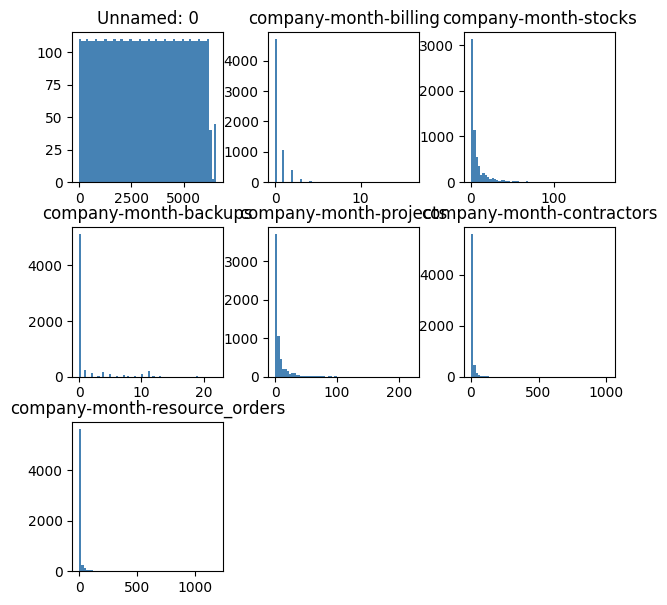

Информация о billing_raw :
Вид данных:


Unnamed: 0  Unnamed: 0.1    id  user_id  company_id  billing_tariff_id  \
0           4             4  3050      567         512                  3   
1           6             6  3051     2861        2474                  7   
2          16            16  3059     1902        1645                  2   
3          18            18  3065     2352        2035                  7   
4          24            24  3062     1074         926                  3   

   payed_until  is_payed  created_at  updated_at  billing_tariff_price_id  \
0   1640153302     False  1608617302  1608617302                     12.0   
1   1640131200      True  1608626162  1608626181                     23.0   
2   1616577484     False  1608801484  1608801484                      6.0   
3   1643500799     False  1608883175  1608883175                     23.0   
4   1611964800      True  1608814072  1608899674                      9.0   

  comment      pay_date  
0     NaN           NaN  
1     NaN  1.608626e+09  
2     NaN           NaN  
3     NaN           NaN  
4     NaN  1.609200e+09


Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               3480 non-null   int64  
 1   Unnamed: 0.1             3480 non-null   int64  
 2   id                       3480 non-null   int64  
 3   user_id                  3480 non-null   int64  
 4   company_id               3480 non-null   int64  
 5   billing_tariff_id        3480 non-null   int64  
 6   payed_until              3480 non-null   int64  
 7   is_payed                 3480 non-null   bool   
 8   created_at               3480 non-null   int64  
 9   updated_at               3480 non-null   int64  
 10  billing_tariff_price_id  3480 non-null   float64
 11  comment                  745 non-null    object 
 12  pay_date                 1108 non-null   float64
dtypes: bool(1), float64(2), int64(9), object(1)
memor

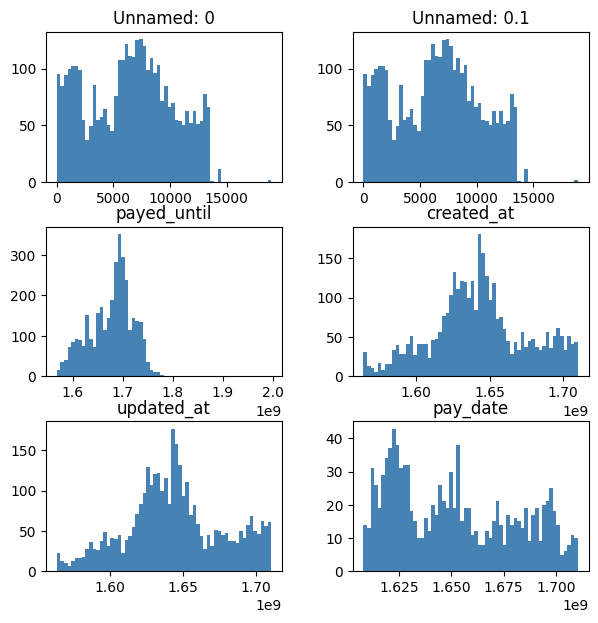

Информация о companies_raw :
Вид данных:


Unnamed: 0   id working_direction  employer_count_interval  created_at  \
0          19  514                 -                      1.0  1571316635   
1          57  383     Строительство                      2.0  1564142565   
2          69  495                 -                      1.0  1570535695   
3          75  724                 -                      1.0  1579514393   
4          99  471                 -                      1.0  1569328017   

   updated_at  billing_tariff_id  billing_is_over  
0  1670298314                4.0             True  
1  1676550050                7.0            False  
2  1598281714                2.0            False  
3  1670298294                4.0             True  
4  1670298360                7.0             True


Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               723 non-null    int64  
 1   id                       723 non-null    int64  
 2   working_direction        720 non-null    object 
 3   employer_count_interval  723 non-null    float64
 4   created_at               723 non-null    int64  
 5   updated_at               723 non-null    int64  
 6   billing_tariff_id        716 non-null    float64
 7   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(1)
memory usage: 40.4+ KB

Распределения числовых величин в данных:


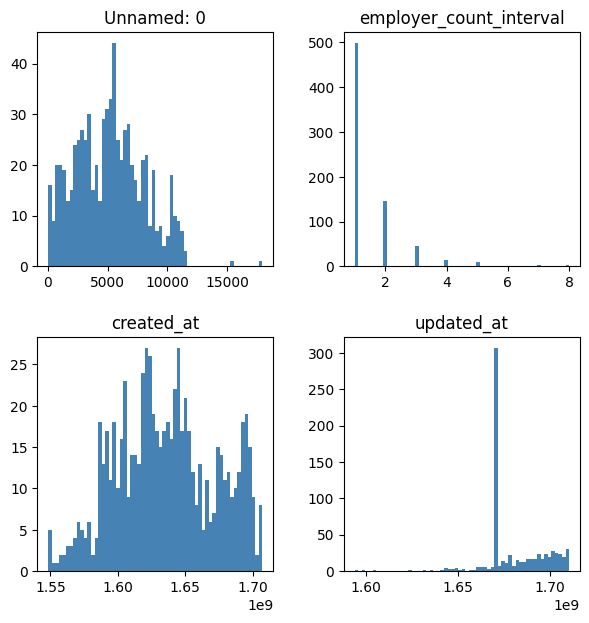

Информация о people_raw :
Вид данных:


Unnamed: 0    id  company_id  user_id  role_id  created_at  updated_at  \
0           2  6601         495      NaN     7133  1570535962  1570535962   
1           6  7025           1      NaN        1  1594120484  1594120484   
2           7  7165        1255   1734.0    18085  1595438102  1595439391   
3          10  7130        1470   1703.0        1  1595234824  1595234824   
4          17  7163        1492   1731.0        1  1595429211  1598540644   

   is_deleted    deleted_at  
0        True  1.594067e+09  
1        True  1.594120e+09  
2        True  1.633960e+09  
3       False           NaN  
4        True  1.620195e+09


Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5095 non-null   int64  
 1   id          5095 non-null   int64  
 2   company_id  5095 non-null   int64  
 3   user_id     3813 non-null   float64
 4   role_id     5095 non-null   int64  
 5   created_at  5095 non-null   int64  
 6   updated_at  5095 non-null   int64  
 7   is_deleted  5095 non-null   bool   
 8   deleted_at  2180 non-null   float64
dtypes: bool(1), float64(2), int64(6)
memory usage: 323.5 KB

Распределения числовых величин в данных:


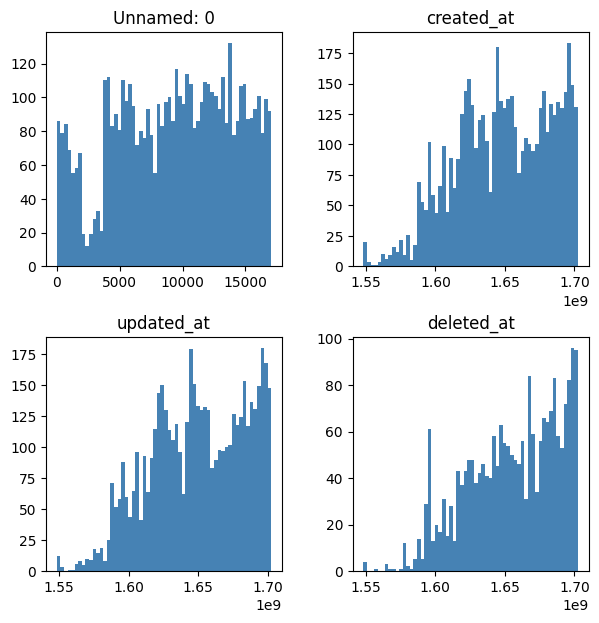

In [22]:
for df in [activities_raw, billing_raw, companies_raw, people_raw]:
    print('Информация о', df.name, ':')
    df_info(df, figsize=(7, 7))

**1. Датасет activites**

Содержит 6316 записей, пропусков в данных нет. По распределению данных можно отметить, что в большинстве случаев компании не активны в течение месяца. Содержит столбец со старыми индексами.

**2. Датасет billing**

Содержит 3480 записей, есть пропуски в столбце с комментариями и с датой оплаты. Присутствует два столбца с, по-видимому, старыми индексами. Столбцы с датами имеют некорректный тип. 

**3. Датасет companies**

Содержит 723 записи, есть пропуски в id приобретенного тарифа, а также пропуски в области деятельности компании. Фактически пропусков в столбце `working_direction` больше, так как часть из них заполнена прочерком. Также содержит столбец старых индексов. Информация о датах представлена некорректно, но по распределению даты в `updated_at` заметен некоторый выброс.

**4. Датасет people**

Содержит 5095 записей, есть пропуски в `user_id` и в `deleted_at`, пропуски в столбце о дате удаления, скорее всего, связана с тем, что данный аккаунт не был удален. Содержит столбец старых индексов. Столбцы с данными представлены некорректно.

Во всех датасетах есть столбцы со старыми индексами. Можно заметить, что во всех датасетах эти индексы следуют не по порядку. Необходимо уточнить особенности выгрузки данных, возможно, что выгрузка происходила с какой-либо фильтрацией и, возможно, было бы полезно узнать, с какой.

## Предобработка данных

In [23]:
# создадим новые датафреймы для дальнейших преобразований
activities = activities_raw.copy(deep=True)
billing = billing_raw.copy(deep=True)
companies = companies_raw.copy(deep=True)
people = people_raw.copy(deep=True)

### Преобразование столбцов

#### Удаление лишних столбцов

In [24]:
activities.drop(columns=['Unnamed: 0'], inplace=True)
billing.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
companies.drop(columns=['Unnamed: 0'], inplace=True)
people.drop(columns=['Unnamed: 0'], inplace=True)

#### Изменение имен столбцов

In [25]:
for col in activities.columns:
    activities = activities.rename(columns={col : col.split('-')[-1]})

In [26]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company_id       6316 non-null   int64  
 1   month            6316 non-null   object 
 2   billing          6316 non-null   float64
 3   stocks           6316 non-null   float64
 4   backups          6316 non-null   float64
 5   projects         6316 non-null   float64
 6   contractors      6316 non-null   float64
 7   resource_orders  6316 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 394.9+ KB


### Поиск дубликатов

In [27]:
activities.name = 'activities'
billing.name = 'billing'
companies.name = 'companies'
people.name = 'people'

In [28]:
for df in [activities, billing, companies, people]:
    if len(df[df.duplicated()]) > 0:
        print('Количество дубликатов в датасете', df.name, f":{len(df[df.duplicated])}.")
    else:
        print(f'Полных дубликатов в {df.name} нет.')

Полных дубликатов в activities нет.
Полных дубликатов в billing нет.
Полных дубликатов в companies нет.
Полных дубликатов в people нет.


Проверим также наличие дубликатов в отдельных датасетах по id.

In [29]:
# проверим уникальные комбинации id в biling
print('Количество дубликатов:', len(billing[billing['id'].duplicated()]))

Количество дубликатов: 0


In [30]:
# проверим уникальные комбинации uid cid и дату создания записи в billing
print('Количество дубликатов:', len(billing[billing[['user_id', 'company_id', 'created_at']].duplicated()]))

Количество дубликатов: 1


In [31]:
for uid in billing[billing[['user_id', 'company_id', 'created_at']].duplicated()]['user_id']:
    for cid in billing[billing[['user_id', 'company_id', 'created_at']].duplicated()]['company_id']:
        for dt in billing[billing[['user_id', 'company_id', 'created_at']].duplicated()]['created_at']:
            display(billing[(billing['user_id'] == uid) & (billing['company_id'] == cid) & (billing['created_at'] == dt)])

id  user_id  company_id  billing_tariff_id  payed_until  is_payed  \
2143  7855     5832        4603                  7   1680176809     False   
2144  7856     5832        4603                  7   1680176809     False   

      created_at  updated_at  billing_tariff_price_id comment  pay_date  
2143  1648640809  1648640809                     23.0     NaN       NaN  
2144  1648640809  1648640809                     23.0     NaN       NaN

Это абсолютно одинаковые строки, в которых отличаются только id записи. Видимо, при сохранении в базу данных произошла какая-то ошибка. Удалим одну из записей.

In [32]:
billing = billing[~(billing[['user_id', 'company_id', 'created_at']].duplicated())]

In [33]:
# проверим уникальные комбинации uid и даты создания записи в companies
print('Количество дубликатов:', len(companies[companies[['id', 'created_at']].duplicated()]))

Количество дубликатов: 0


In [34]:
# проверим уникальные комбинации id в billing
print('Количество дубликатов:', len(people[people['id'].duplicated()]))

Количество дубликатов: 0


In [35]:
# проверим уникальные комбинации в people
print('Количество дубликатов:', len(people[people[['user_id', 'company_id', 'created_at']].duplicated()]))

Количество дубликатов: 38


In [36]:
people[people[['user_id', 'company_id', 'created_at']].duplicated()].head()

id  company_id  user_id  role_id  created_at  updated_at  is_deleted  \
29   7102        1255      NaN    18085  1594820302  1594820302        True   
52   7103        1255      NaN    18085  1594820302  1594820302        True   
151  8685        1975      NaN        1  1610419926  1610419926        True   
301  7682        1782      NaN    25490  1600870314  1600870314        True   
619  6401         218      NaN     3126  1552132278  1552132278       False   

       deleted_at  
29   1.594821e+09  
52   1.594821e+09  
151  1.610421e+09  
301  1.602660e+09  
619           NaN

По-видимому, все найденные дубликаты связаны с записями, где есть пропуски в `user_id`. Проверим это.

In [37]:
# посмотрим на дубликаты без пропусков
print('Количество дубликатов:', 
      len(people[(people[['user_id', 'company_id', 'created_at']].duplicated()) & ~(people['user_id'].isna())]))

Количество дубликатов: 0


Дубликаты не найдены. В сервисе добавление участников может происходить одновременно: создатель проекта открывает окно добавления участников проекта и указывает почту для отправления приглашения присоединиться к приложению, после чего нажимает кнопку для отправки предложений и закрытия окна подключения сотрудников. По-видимому, в этот момент в базе данных одновременно создаётся несколько записей с пустыми user_id (пока сотрудник не ответил на приглашение и не присоединился к проекту в приложении, ему не будет присвоен идентификатор), но заполненными `company_id`, `created_at` и остальными данными, поэтому по этим полям появляются дубликаты.

In [38]:
# посмотрим, есть ли дубликаты в id записи
print('Количество дубликатов:', 
      len(people[(people['id'].duplicated())]))

Количество дубликатов: 0


In [39]:
# посмотрим, есть ли дубликаты уникальных пар cid и uid
print('Количество дубликатов:', 
      len(people[(people[['user_id', 'company_id']].duplicated()) & ~(people['user_id'].isna())]))

Количество дубликатов: 250


Такие повторы есть. Возможно, что повторы связаны с тем, что компания может иметь несколько проектов, и к каждому проекту добавлять нужных сотрудников отдельно, сотрудники при этом могут быть одни и теже сразу на нескольких проектах компании. В таком случае столбец `is_deleted` необходимо воспринимать не как удаление профиля пользователя приложения, а как удаление сотрудника из проекта. Поэтому в датасете остаётся уникальный номер комбинации (колонка `id`), который, вероятно, используется в отдельных таблицах проектов компаний. 

В противном случае, это могут быть ошибки системы или результат восстановления профилей раннее удаленных аккаунтов.

***Далее будем считать, что отметка в столбце `is_deleted` связана с удалением пользователя из списка сотрудников для конкретного проекта.***

### Изменение типов данных

In [40]:
activities['month'] = pd.to_datetime(activities['month']).dt.date

In [41]:
to_datetime(billing, ['payed_until', 'created_at', 'updated_at', 'pay_date'], date=True)
to_datetime(companies, ['created_at', 'updated_at'], date=True)
to_datetime(people, ['created_at', 'updated_at', 'deleted_at'], date=True)

In [42]:
# check
display(billing.head())
display(companies.head())
people.head()

id  user_id  company_id  billing_tariff_id payed_until  is_payed  \
0  3050      567         512                  3  2021-12-22     False   
1  3051     2861        2474                  7  2021-12-22      True   
2  3059     1902        1645                  2  2021-03-24     False   
3  3065     2352        2035                  7  2022-01-29     False   
4  3062     1074         926                  3  2021-01-30      True   

   created_at  updated_at  billing_tariff_price_id comment    pay_date  
0  2020-12-22  2020-12-22                     12.0     NaN         NaT  
1  2020-12-22  2020-12-22                     23.0     NaN  2020-12-22  
2  2020-12-24  2020-12-24                      6.0     NaN         NaT  
3  2020-12-25  2020-12-25                     23.0     NaN         NaT  
4  2020-12-24  2020-12-25                      9.0     NaN  2020-12-29

id working_direction  employer_count_interval  created_at  updated_at  \
0  514                 -                      1.0  2019-10-17  2022-12-06   
1  383     Строительство                      2.0  2019-07-26  2023-02-16   
2  495                 -                      1.0  2019-10-08  2020-08-24   
3  724                 -                      1.0  2020-01-20  2022-12-06   
4  471                 -                      1.0  2019-09-24  2022-12-06   

   billing_tariff_id  billing_is_over  
0                4.0             True  
1                7.0            False  
2                2.0            False  
3                4.0             True  
4                7.0             True

id  company_id  user_id  role_id  created_at  updated_at  is_deleted  \
0  6601         495      NaN     7133  2019-10-08  2019-10-08        True   
1  7025           1      NaN        1  2020-07-07  2020-07-07        True   
2  7165        1255   1734.0    18085  2020-07-22  2020-07-22        True   
3  7130        1470   1703.0        1  2020-07-20  2020-07-20       False   
4  7163        1492   1731.0        1  2020-07-22  2020-08-27        True   

   deleted_at  
0  2020-07-06  
1  2020-07-07  
2  2021-10-11  
3         NaT  
4  2021-05-05

In [43]:
billing.loc[:, 'billing_tariff_price_id'] = billing['billing_tariff_price_id'].astype('int')

In [44]:
companies.loc[:, 'employer_count_interval'] = companies['employer_count_interval'].astype('int')

### Отбор данных для исследования

Для исследования оттока нам не понадобятся компании, пользующиеся только пробными, промо и бесплатными тарифами (1, 18, 22). Исследуем датасеты companies и billing, чтобы отсеять компании, которые ни разу не подключали подписку.

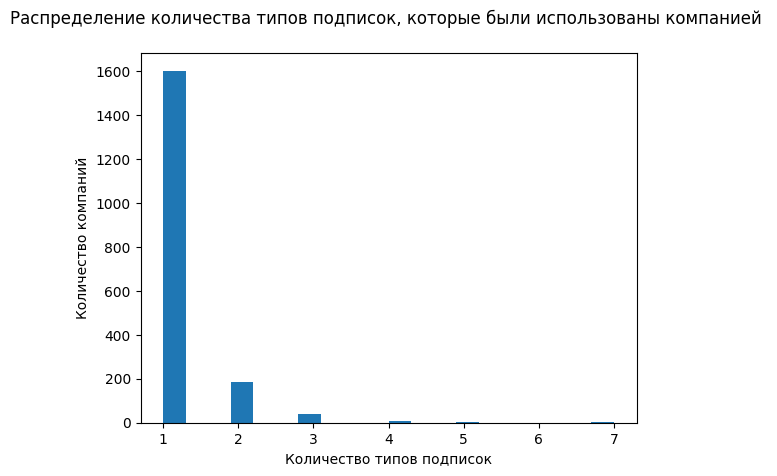

In [45]:
(
    billing
    .groupby('company_id')
    .agg({
        'billing_tariff_id' : 'nunique'
    })
    .sort_values(by='billing_tariff_id', ascending=False)
    .hist(grid=False, bins=20)
);
plt.title('Распределение количества типов подписок, которые были использованы компанией \n')
plt.xlabel('Количество типов подписок')
plt.ylabel('Количество компаний');

В данных большинство компаний использовали только один тип подписок. Есть некоторые, которые использовали и 7 типов подписок. 

Сначала отберем подходящие компании среди тех, кто воспользовался только одним типом подписки.

In [46]:
not_interesting_cids = []
for cid in (
    billing
    .groupby('company_id')
    .agg({
        'billing_tariff_id' : 'nunique'
    })
    .query('billing_tariff_id == 1')
    .index
):
    if billing.loc[billing['company_id'] == cid, 'billing_tariff_id'].unique() in [1, 18, 22]:
        not_interesting_cids.append(cid)
        billing = billing[~(billing['company_id'] == cid)]
        
print('Количество компаний, которые не использовали платные тарифы среди тех, которые подключали только один тариф:',
     len(not_interesting_cids))

Количество компаний, которые не использовали платные тарифы среди тех, которые подключали только один тариф: 0


Все компании, которые подключали только 1 тариф, использовали именно платные подписки.

In [47]:
# проверим теперь остальные компании
for cid in (
    billing
    .groupby('company_id')
    .agg({
        'billing_tariff_id' : 'nunique'
    })
    .query('billing_tariff_id != 1')
    .index
):
    if len([t for t in billing.loc[billing['company_id'] == cid, 'billing_tariff_id'].unique() if t not in [1, 18, 22]]) == 0 :
        not_interesting_cids.append(cid)
        billing = billing[~(billing['company_id'] == cid)]
        
print('Количество компаний, которые не использовали платные тарифы:',
     len(not_interesting_cids))

Количество компаний, которые не использовали платные тарифы: 0


В датасете billing все компании так или иначе подключали платные подписки (возможно, именно такую фильтрацию проходили id компаний при запросе к БД: чтобы не было компаний, которые подключали только бесплатные подписки). Однако, судя по виду датасета, запись в этой таблице создаётся в момент, когда только подаётся заявка на оформление подписки, наличие записи ещё не подтверждает факт оплаты и подключения подписки. Возможно, что компания подключает подписку, пользуется её бесплатным периодом и только потом принимает решение об оплате подписки (тогда запись создаётся в момент подключения подписки, но столбец с датой оплаты остаётся пустым).

In [48]:
# взглянем на датасет ещё раз
billing.head()

id  user_id  company_id  billing_tariff_id payed_until  is_payed  \
0  3050      567         512                  3  2021-12-22     False   
1  3051     2861        2474                  7  2021-12-22      True   
2  3059     1902        1645                  2  2021-03-24     False   
3  3065     2352        2035                  7  2022-01-29     False   
4  3062     1074         926                  3  2021-01-30      True   

   created_at  updated_at  billing_tariff_price_id comment    pay_date  
0  2020-12-22  2020-12-22                       12     NaN         NaT  
1  2020-12-22  2020-12-22                       23     NaN  2020-12-22  
2  2020-12-24  2020-12-24                        6     NaN         NaT  
3  2020-12-25  2020-12-25                       23     NaN         NaT  
4  2020-12-24  2020-12-25                        9     NaN  2020-12-29

В датасете есть столбцы `is_payed` и `pay_date`, которые должны отвечать на вопрос о факте оплаты подписки. Проверим для начала, что между столбцами нет противоречий.

In [49]:
print('Общее количество несовпадений:',
      len(billing[(billing['is_payed'] == True) & (billing['pay_date'].isna())]) + \
      len(billing[(billing['is_payed'] == False) & ~(billing['pay_date'].isna())]), 
      '({n:.2%})'.format(
          n=
          (len(billing[(billing['is_payed'] == True) & (billing['pay_date'].isna())]) + \
          len(billing[(billing['is_payed'] == False) & ~(billing['pay_date'].isna())])) / len(billing)
      )
     )

Общее количество несовпадений: 482 (13.85%)


Всего в записях есть 482 несовпадения, что составляет почти 14% от всех записей в датасете. На этом шаге обратим внимание на столбец `comment`.

Можно обратить внимание, что в некоторых случаях компания предоставляет индивидуальный подход: замораживает подписку, продлевает подписки бесплатно партнёрам или участникам отдельных мероприятий компания, предоставляет частичную оплату, есть случаи запроса возвратов, бесплатного продления за счет акций, пересчет на другие тарифы. 

Комментариями также проясняется наличие столбца `updated_at`, рассмотрим на примере ниже.

In [51]:
billing[billing['company_id'] == 2507]

id  user_id  company_id  billing_tariff_id payed_until  is_payed  \
15   3057     2920        2507                  4  2021-06-23     False   
529  3392     2920        2507                  7  2021-11-06      True   

     created_at  updated_at  billing_tariff_price_id  \
15   2020-12-23  2020-12-23                       15   
529  2021-02-10  2021-05-06                       22   

                                               comment    pay_date  
15   23,12 - оплатили, ожидаем в январе сообщение о...  2020-12-25  
529  20,02 - заморозили по просьбе клиента . 19,02 ...  2021-02-10

In [52]:
billing[billing['company_id'] == 2507]['comment'].unique()

array(['23,12 - оплатили, ожидаем в январе сообщение об активации тарифа',
       '20,02 - заморозили по просьбе клиента . 19,02 прошло обучение, где крайне недоволен был текущим функционалом. Было предложено заморозить тариф, (срок было по 11,08,21), отправили ему официальное письмо по его запросам, Грант подтвердил\r\n06.05,21 - активировала обратно, сообщила, что добавили акты с ресурсами'],
      dtype=object)

В billing была создана 23 декабря 2020 года запись о подписке компании с id 2507. Подписка должна была быть активирована в январе 2021 года. Дата оплаты подписки по данной заявке стоит позднее: 25 декабря 2020 года (оплата действительно произошла, как следует из комментария), при этом в столбце `is_payed` отмечено False. Видимо, если оплата подписки происходит не сразу (возможно, оплата произведена после общения клиента с менеджером Компании или же данные об оплате занесены позже из-за ошибок в системе (при автоматическом заполнении) или же из-за ручного внесения данных), то столбец `is_payed` заполняется как False. ***По этой причине при противоречиях факт оплаты будем далее оценивать по столбцу `pay_date`.***

Далее, 10 февраля была создана новая запись для этой же компании. Видимо, была произведена ещё одна оплата (продление подписки? обучение?), тип подписки не изменился, при этом клиент попросил заморозить подписку до появления необходимого ему функционала. Далее 6 мая запись была обновлена, подписка была активирована, при этом срок платежа сместился на срок ожидания клиентом функционала.

В таком случае:
- Во-первых, для противоречивых записей будем считать, что ***если в столбце `pay_date` указана дата, то подписка была оплачена***. 
- Во-вторых, если дата не указана, а в `is_payed` стоит True, то считаем, что клиент воспользовался бесплатным периодом подписки, но далее платить не стал. 
- В-третьих, если оба столбца пустые, то считаем, что это либо ошибка в данных, либо клиент пользовался только бесплатными тарифами (или бесплатными периодами).
- Некоторые сомнительные/неоднозначные ситуации при необходимости можно изучить внимательным прочтением комментариев к оплатам интересующей компании.

Исходя из предположений, сделанных выше, очистим датасет от компаний, которые не пользовались платными подписками.

In [53]:
# оставим данные только о тех компаниях, среди записей о которых есть не пустые значения в `pay_date`
billing = billing[billing['company_id'].isin(
    billing
    .groupby('company_id')
    .agg({'pay_date' : 'count'})
    .query('pay_date > 0')
    .index
)]

In [54]:
print('Доля удаленных данных:', 
      f"{(len(billing_raw) - len(billing)) / len(billing_raw):.2%}"
     )

Доля удаленных данных: 44.14%


Таким образом, в датасете billing остались записи о платежах только тех компаний, которые совершали покупку платных подписок хотя бы раз. Теперь оставим в остальных датасетах информацию только об этих компаниях.

In [55]:
activities = activities[activities['company_id'].isin(billing['company_id'].unique())]
companies = companies[companies['id'].isin(billing['company_id'].unique())]
people = people[people['company_id'].isin(billing['company_id'].unique())]

In [56]:
print('Количество компаний в датасете billing:', len(billing['company_id'].unique()))
print('Количество компаний в датасете activities:', len(activities['company_id'].unique()))
print('Количество компаний в датасете people:', len(people['company_id'].unique()))
print('Количество компаний в датасете companies:', len(companies['id'].unique()))

Количество компаний в датасете billing: 774
Количество компаний в датасете activities: 620
Количество компаний в датасете people: 610
Количество компаний в датасете companies: 620


Не о всех компаниях, о которых есть информация в billing, есть информация в других датасетах, таких компаний более 100.

In [57]:
# выделим "лишние" компании
extra_cids = billing.loc[~(billing['company_id'].isin(activities['company_id'].unique())), 'company_id'].unique()

In [58]:
billing.head(2)

id  user_id  company_id  billing_tariff_id payed_until  is_payed  \
1  3051     2861        2474                  7  2021-12-22      True   
2  3059     1902        1645                  2  2021-03-24     False   

   created_at  updated_at  billing_tariff_price_id comment    pay_date  
1  2020-12-22  2020-12-22                       23     NaN  2020-12-22  
2  2020-12-24  2020-12-24                        6     NaN         NaT

In [59]:
table_of_connection = billing.copy(deep=True)
table_of_connection['extra_cid_flag'] = 0
table_of_connection.loc[table_of_connection['company_id'].isin(extra_cids), 'extra_cid_flag'] = 1
table_of_connection['creation_year'] = pd.to_datetime(table_of_connection['created_at']).dt.year
table_of_connection['updation_year'] = pd.to_datetime(table_of_connection['updated_at']).dt.year

(
    table_of_connection
    .groupby('extra_cid_flag')    
    .agg({
        'billing_tariff_id' : pd.Series.mode,
        'is_payed' : 'mean',
        'updated_at' : pd.Series.mode,
        'billing_tariff_price_id' : pd.Series.mode,
        'creation_year' : pd.Series.mode
    })
)

billing_tariff_id  is_payed  \
extra_cid_flag                                
0                               2  0.637701   
1                               2  0.141199   

                                                      updated_at  \
extra_cid_flag                                                     
0                                                     2022-07-25   
1               [2021-07-06, 2022-04-04, 2022-12-21, 2023-01-27]   

                billing_tariff_price_id  creation_year  
extra_cid_flag                                          
0                                    23           2021  
1                                     8           2021

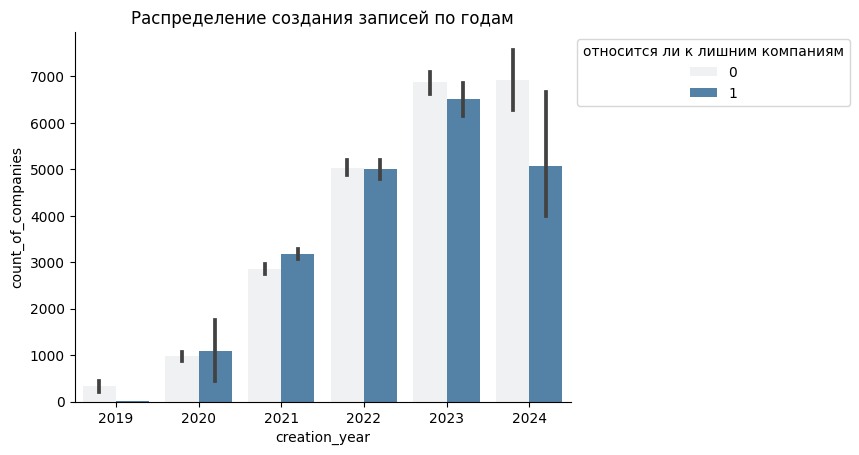

In [60]:
sns.barplot(
    data=table_of_connection,
    x='creation_year',
    y='company_id',
    hue='extra_cid_flag',
    color='steelblue'
)
plt.title('Распределение создания записей по годам')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, title='относится ли к лишним компаниям')
plt.ylabel('count_of_companies')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

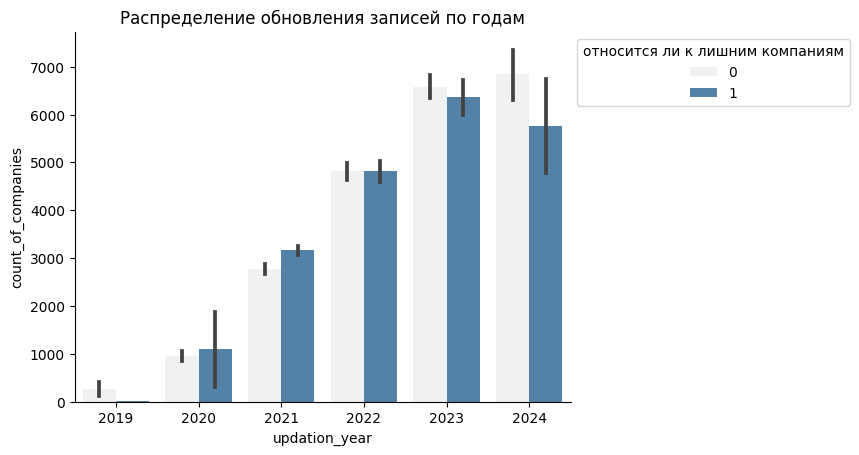

In [61]:
sns.barplot(
    data=table_of_connection,
    x='updation_year',
    y='company_id',
    hue='extra_cid_flag',
    color='steelblue'
)
plt.title('Распределение обновления записей по годам')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, title='относится ли к лишним компаниям')
plt.ylabel('count_of_companies')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Не удалось выделить каких-либо характерных особенностей для компаний, информация о которых представлена только в датасете billing, такие компании появлялись в данных в течение всего времени равномерно. Тем не менее, ***необходимо выяснить, почему о некоторых компаниях нет никакой информации, кроме как об их платежах в billing.***

Посмотрим также на количество новых компаний по месяцам.

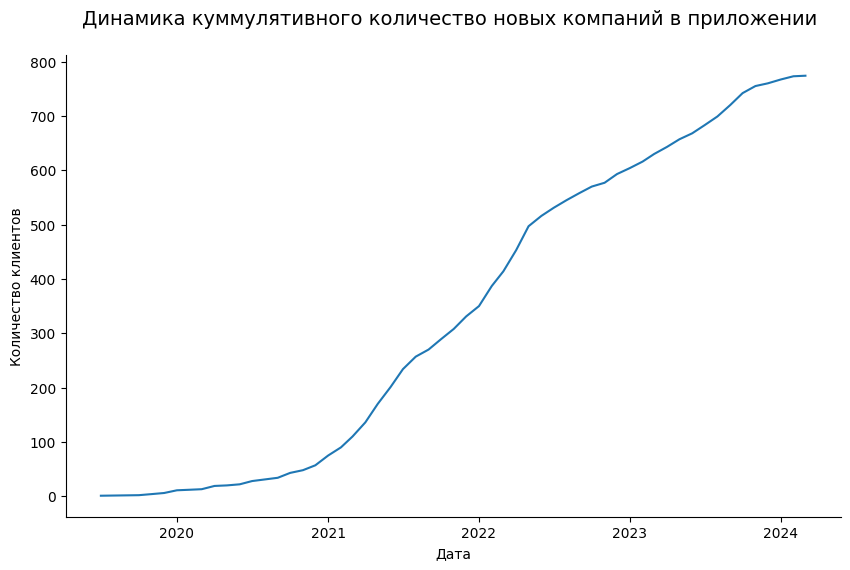

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(left=False, ax=ax)
ax.plot(
    billing
    .groupby('company_id')
    .agg({'created_at' : 'min'})
    .astype("datetime64[M]")
    .reset_index()
    .groupby('created_at')
    .agg({'company_id' : 'count'})
    .rename(columns={'company_id' : 'count_of_companies'})
    .sort_values(by='created_at')
    .cumsum(axis=0)
)
plt.title('Динамика куммулятивного количества новых компаний в приложении \n', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество клиентов');

In [63]:
new_companies_graph()

За 2019 год представлена не полная информация, а только с середины октября. Возможно, это частично является причиной высокой доли записей с неоплаченной подпиской в этом году. ***Уточнить, с какого момента в компании ведётся база данных в данном виде.***

До ноября 2020 года количество клиентов приложения в целом и количество новых клиентов в месяц низкие. Так как Компания активно развивает приложение и вводит новые функции и, как следствие, версии приложения 2020 года и 2024 года могут сильно отличаться, то учитывать в анализе редкие старые записи будет некорректно. ***Будем далее рассматривать только компании, которые впервые начали использовать приложение после ноября 2020 года.***

In [64]:
d=pd.to_datetime('11.01.2020')

actual_cids = (
    billing
    .groupby('company_id')
    .agg({'created_at' : 'min'})
    .astype("datetime64[M]")
    .query('created_at > @d')
    .sort_values(by='created_at')
)

actual_cids = actual_cids.index

In [65]:
# очистим остальные датасеты от данных отброшенных компаний
billing = billing[(billing['company_id'].isin(actual_cids))]
people = people[(people['company_id'].isin(actual_cids))]
companies = companies[(companies['id'].isin(actual_cids))]
activities = activities[(activities['company_id'].isin(actual_cids))]

### Работа с пропусками

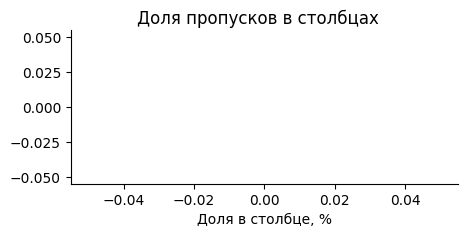

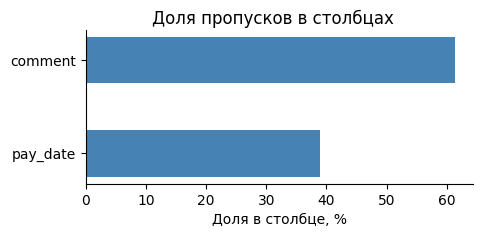

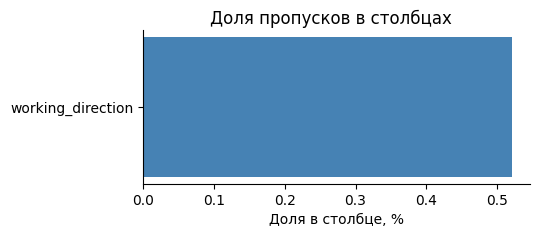

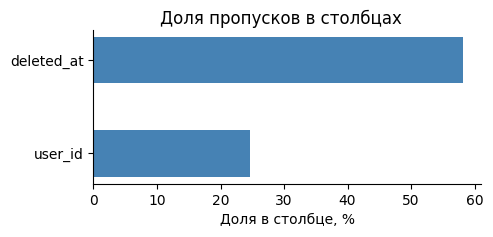

In [66]:
# построим график, отражающий для каждого столбца долю пропусков в нём
for df in [activities, billing, companies, people]:
    pass_value_barh(df)

В датасете activities пропусков нет. 

В датасете billing есть пропуски в столбцах `comment` и `pay_date`. Комментарии указаны не у всех записей, эти пропуски не заполняем. Пропуски в `pay_date`, как было отмечено в шаге 2.4, считаем связанными с тем, что компания использовала пробные тарифы.

Проверим, есть ли связь между пропуском в `pay_date` и датой создания записи в billing.

Можно заметить, что в 2019 и 2020 году доля пустых значений в `pay_date` довольно высока: 100% для записей, созданных в 2019 году и около 60% для 2020 года (в остальные года доли распределены примерно поровну). Возникает вопрос, ***есть ли достоверная информация касаемо оплаченных подписок в 2019 году? Возможно, что столбец о дате оплаты был введён только в 2020-м году?***

In [67]:
# проверим самую раннюю дату в billing
print('Самая ранняя дата создания записи:', billing['created_at'].min())

Самая ранняя дата создания записи: 2020-12-03


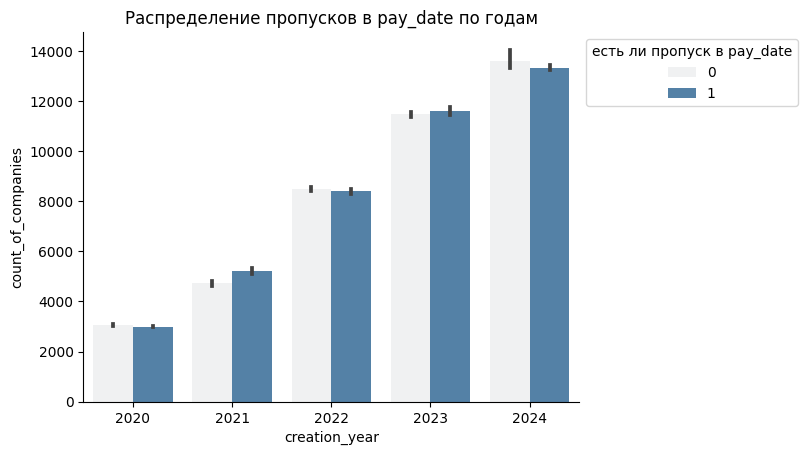

In [68]:
table_of_connection = billing.copy(deep=True)
table_of_connection['pass_flag'] = 0
table_of_connection.loc[table_of_connection['pay_date'].isna(), 'pass_flag'] = 1
table_of_connection['creation_year'] = pd.to_datetime(table_of_connection['created_at']).dt.year

sns.barplot(
    data=table_of_connection,
    x='creation_year',
    y='id',
    hue='pass_flag',
    color='steelblue'
)
plt.title('Распределение пропусков в pay_date по годам')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, title='есть ли пропуск в pay_date')
plt.ylabel('count_of_companies')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Записи, в которых отсутствует дата оплаты, распределены равномерно по всем годам.

В датасете companies пропуски в столбце `working_direction` составляют практически половину. Этот пункт заполняется пользователями самостоятельно при заполнении описания компании. Изучим значения в этом столбце.

In [69]:
companies['working_direction'].value_counts()

-                                                      358
Строительство                                           42
строительство                                            6
Малоэтажное строительство                                5
-строительство                                           4
                                                      ... 
Электромонтажные работы                                  1
Монтаж инженерных систем                                 1
-малоэтажное строительство                               1
Генеральный подряд                                       1
Строительство и проектирование зданий и сооружений       1
Name: working_direction, Length: 146, dtype: int64

Прочерк также является пустым значением, поэтому заменим прочерки на Null.

In [70]:
companies.loc[companies['working_direction'] == '-', 'working_direction'] = None

In [71]:
# приведем все строки к нижнему регистру
companies['working_direction'] = companies['working_direction'].str.lower().str.strip().str.strip('-')

По имеющимся данным мы не можем заполнить пропуски вручную.

Пропуски в датасете people в столбце `deleted_at`, скорее всего, связаны с пользователями, которые были удалены из проектов компании или которые удалили свои профили самостоятельно. А вот пропуски в `user_id`, по-видимому, связаны с пользователями, которым было отправлено приглашение присоединиться к проекту в приложении, но эти люди не приняли это приглашение.

In [72]:
# проверим, что пропуски в deleted_at совпадает со значением в is_deleted
print('Количество несовпадений:',
      len(people[(people['is_deleted'] == True) & (people['deleted_at'].isna())]) +\
      len(people[(people['is_deleted'] == False) & ~(people['deleted_at'].isna())])
     )

Количество несовпадений: 0


Посмотрим, как связаны между собой пропуски в столбцах `user_id`, `deleted_at` в датасете people.

In [73]:
table_of_connection = (
    people
    .groupby('is_deleted')
    .agg({
        'user_id' : 'count',
        'id' : 'count'
    })
    .rename(columns={
        'user_id' : 'count_of_not_null_users',
        'id' : 'total_count_in_group'
    })
)
table_of_connection['ratio_in_percent'] = round(
    table_of_connection['count_of_not_null_users'] / table_of_connection['total_count_in_group'] * 100,
    2
)
table_of_connection

count_of_not_null_users  total_count_in_group  ratio_in_percent
is_deleted                                                                 
False                          2198                  2450             89.71
True                            977                  1767             55.29

Получаем, что среди записей о сотрудниках, которые не были удалены из проекта компании, есть 10% пропусков в `user_id`. Среди тех сотрудников, которые были удалены, пропуски в `user_id` распределены практически пополам.

Исходя из этого можно сделать несколько предположений:

1. Если проект открыт и сотрудники-исполнители данного проекта компании не удалены из этого проекта, то ***90% этих сотрудников по крайней мере принимают приглашения и регистрируются в приложении***. Т.е., можно предположить, что если компания ожидает от сотрудников подключения к проекту, то 90% сотрудников принимает это приглашение.

2. Сильной связи между удалением профиля сотрудника и фактом регистрации этого сотрудника в приложении нет. Создатель проекта может удалять неприсоединившегося сотрудника из проекта как просто так, так и чтобы пригласить другого сотрудника (в подписках может быть ограничено количество сотрудников на проект) или по причине удаления всего проекта. При этом даже если сотрудник регистрировался в приложении, удаление его из проекта могло происходить по всем тем же причинам. Кроме того, это могут быть и случаи удаления сотрудника, который сначала присоединился к проекту, а затем полностью удалил свой профиль из приложения. Таким образом, по данной группе каких-либо выделенных предположений не сделать.

### Поиск аномалий

#### Датасет activities

В датасете activities распределения количества каждого типа действий в месяц имеет пуассоновский вид (большая частота для 0-1 значений и хвост редких высоких значений). Чтобы исследовать аномалии посмотрим также среднее количество действий каждого типа, совершаемое в месяц, для каждой компании.

In [74]:
# сначала проверим, что нет некорретных значений
i=0
for col in [x for x in activities.columns if x not in ['month', 'company_id']]:
    i += len(activities[activities[col] < 0])
    
print('Количество некорректных значений:', i)

Количество некорректных значений: 0


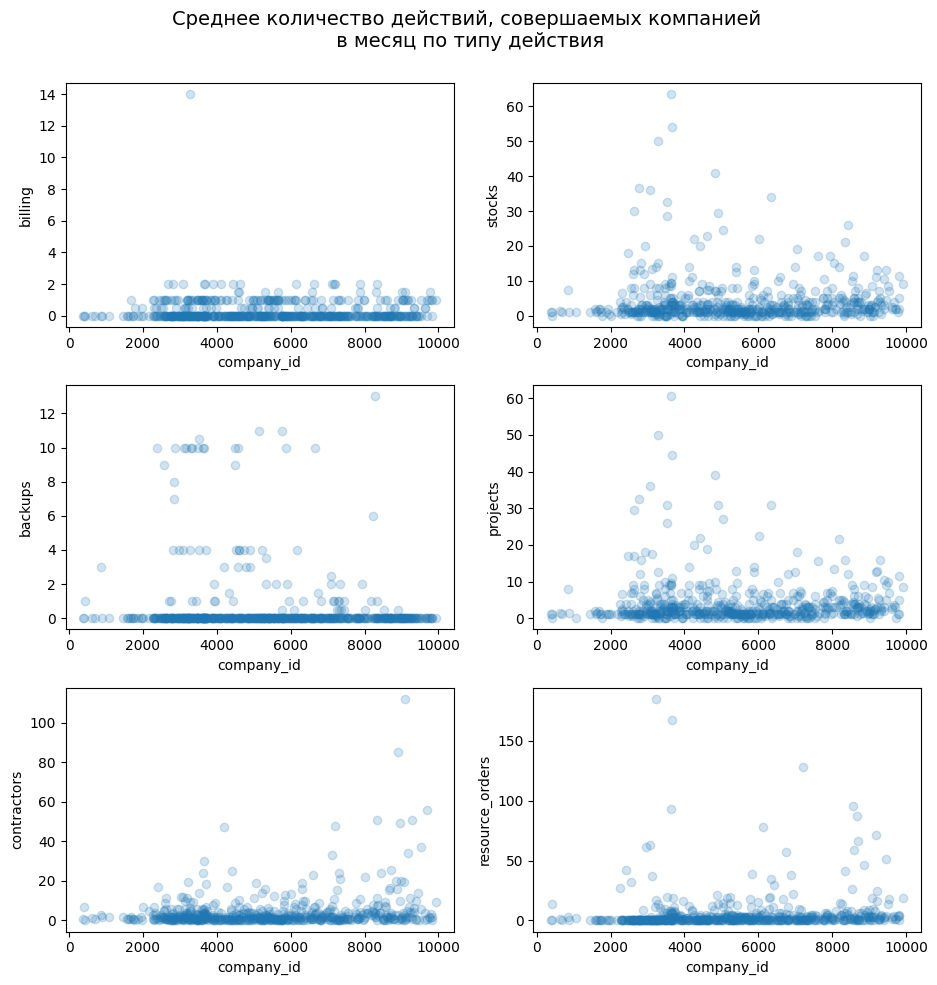

In [75]:
fig, axes = plt.subplots(3, 2, figsize=(9.5, 10))
fig.suptitle('Среднее количество действий, совершаемых компанией \n в месяц по типу действия \n', fontsize=14)
i=0

for col in [x for x in activities.columns if x not in ['month', 'company_id']]:
    s = i // 2
    t = i % 2
    
    sns.regplot(
        data=(
            activities
            .groupby('company_id')
            .agg({
                **dict.fromkeys(
                    [x for x in activities.columns if x not in ['month', 'company_id']], 'median'
                )
            })
            .reset_index()
        ),
         x='company_id', y=col, ax=axes[s, t], fit_reg=False, scatter_kws={"alpha":0.2}
    )
    i+=1

plt.tight_layout()

Для некоторых действий (billing, contractors) можно относительно просто определить выбивающиеся значения. В остальных случаях визуально сложно выбрать границу, поэтому для этих ситуаций воспользуемся перцентилями и уберем то, что выходит за 99-й перцентиль.

In [76]:
for col in [x for x in activities.columns if x not in ['month', 'company_id']]:
    print('Для столбца', col)
    print()
    percentils(
        (
            activities
            .groupby('company_id')
            .agg({
                **dict.fromkeys(
                    [x for x in activities.columns if x not in ['month', 'company_id']], 'median'
                )
            })
            .reset_index()
        ),
        col
    )
    print()

Для столбца billing

90-й перцентиль: 1.00
95-й перцентиль: 1.00
99-й перцентиль: 2.00

Для столбца stocks

90-й перцентиль: 9.00
95-й перцентиль: 14.00
99-й перцентиль: 34.50

Для столбца backups

90-й перцентиль: 1.00
95-й перцентиль: 4.00
99-й перцентиль: 10.00

Для столбца projects

90-й перцентиль: 9.00
95-й перцентиль: 13.12
99-й перцентиль: 31.38

Для столбца contractors

90-й перцентиль: 9.50
95-й перцентиль: 16.62
99-й перцентиль: 47.88

Для столбца resource_orders

90-й перцентиль: 11.00
95-й перцентиль: 20.00
99-й перцентиль: 80.25



Проведем очистку согласно полученным значениям: оставим компании, для которых среднее количество действий не выходит за 99-й процентиль.

In [77]:
old_cids = activities['company_id'].unique()
clean_activities(activities)

# выделим id компаний, которые были удалены
cids_for_clean = []
for cid in old_cids:
    if cid not in activities['company_id'].unique():
        cids_for_clean.append(cid)

In [78]:
# очистим остальные датасеты от данных отброшенных компаний
billing = billing[~(billing['company_id'].isin(cids_for_clean))]
people = people[~(people['company_id'].isin(cids_for_clean))]
companies = companies[~(companies['id'].isin(cids_for_clean))]

In [79]:
del cids_for_clean

#### Датасет billing

В столбце `payed_until` наблюдался длинный хвост крайне редких значений. Посмотрим разброс оплат подписок среди записей, в которых, скорее всего, действительно была произведена оплата.

In [80]:
billing.head()

id  user_id  company_id  billing_tariff_id payed_until  is_payed  \
1   3051     2861        2474                  7  2021-12-22      True   
6   3098     2707        2353                  2  2021-06-30      True   
10  3131     2989        2565                  2  2021-07-11     False   
13  4854     4451        3633                  7  2021-08-13      True   
15  3057     2920        2507                  4  2021-06-23     False   

    created_at  updated_at  billing_tariff_price_id  \
1   2020-12-22  2020-12-22                       23   
6   2020-12-29  2020-12-30                        7   
10  2021-01-11  2021-01-11                        7   
13  2021-07-21  2021-08-11                       23   
15  2020-12-23  2020-12-23                       15   

                                              comment    pay_date  
1                                                 NaN  2020-12-22  
6                               30,12 - пришла оплата  2020-12-29  
10                                                NaN         NaT  
13        оплата пришла 5,08\r\nПереоткрыла другой лк  2021-08-05  
15  23,12 - оплатили, ожидаем в январе сообщение о...  2020-12-25

In [81]:
print('Минимальная дата в датасете:', 
    billing[~(billing['pay_date'].isna())]['payed_until'].min()
)
print('Максимальная дата в датасете:',
    billing[~(billing['pay_date'].isna())]['payed_until'].max()
)

Минимальная дата в датасете: 2021-01-27
Максимальная дата в датасете: 2026-06-12


Среди оплаченных подписок аномально далеких дат нет. Тем не менее, два года (при условии оформления в 2024 году) достаточно большой промежуток (стандартно подписка предлагается на год). Проверим, много ли подписок, оформленных до 2026 года.

In [82]:
print(
    'Количество подписок, оформленных до 2026 года:',
len(billing[pd.to_datetime(billing['payed_until']).dt.year == pd.to_datetime('2026-06-12').year]))
billing[pd.to_datetime(billing['payed_until']).dt.year == pd.to_datetime('2026-06-12').year]

Количество подписок, оформленных до 2026 года: 13


id  user_id  company_id  billing_tariff_id payed_until  is_payed  \
1480   6146     4622        3752                  7  2026-09-18     False   
2807   8840     6847        5342                  2  2026-04-08      True   
3188  12203    11872        8789                  7  2026-01-29      True   
3250  12588     6683        5233                  7  2026-04-01      True   
3251  12571    12498        9243                  9  2026-04-01     False   
3252  12596    12498        9243                 20  2026-04-03      True   
3260  12640    12162        8996                  7  2026-03-08      True   
3270   5584     5110        4100                  9  2026-03-17      True   
3348  13060     7969        6131                  2  2026-01-05     False   
3364  13028    11464        8495                 20  2026-06-12      True   
3379  13164     6236        4902                  2  2026-01-17     False   
3406   8921     3786        3158                  2  2026-06-02      True   
3442  13423     7217        5591                  2  2026-02-04      True   

      created_at  updated_at  billing_tariff_price_id  \
1480  2021-11-12  2021-11-12                       34   
2807  2022-07-07  2023-02-06                        8   
3188  2023-09-29  2023-09-29                       34   
3250  2023-11-01  2023-11-01                       34   
3251  2023-10-31  2023-11-02                       36   
3252  2023-11-02  2023-11-02                       19   
3260  2023-11-08  2023-11-08                       34   
3270  2021-09-23  2023-11-17                       36   
3348  2024-01-05  2024-01-05                       35   
3364  2023-12-29  2024-01-12                       19   
3379  2024-01-17  2024-01-17                       35   
3406  2022-07-18  2024-02-02                       35   
3442  2024-02-14  2024-02-21                       24   

                                                comment    pay_date  
1480                                                NaN         NaT  
2807                                                NaN  2022-07-07  
3188                                               24+4  2023-09-29  
3250                                               24+4  2023-11-01  
3251                                      03,11,23-24+5  2023-11-02  
3252                                      03,11,23-24+5  2023-11-02  
3260                                               24+4  2023-11-08  
3270  Активация тарифа по запросу от 8,11 переноситс...  2021-09-24  
3348                                                NaN         NaT  
3364                                    12,01,24 - 24+5  2024-01-12  
3379                                                NaN         NaT  
3406  14,09,22 - активация доступа 24+4\r\n02,02,24-...  2022-09-14  
3442                       04,04,24- запуск тарифа 18+4  2024-02-21

Есть несколько компаний, которые оформили подписку до 2026 года. При этом некоторые компании не пользовались подпиской (активировали заново спустя 2 года, и это отображено как комментарий в таблице, а не как новая запись), и нет информации о дальнейших платежах (неизвестно, оплачивали ли компании подписку разом на несколько месяцев или всё-таки должны платить раз в месяц? не до конца ясен смысл комментариев, дают ли они просто количество месяцев, на которое оформлена подписка, или сразу отмечают количество месяцев, за которое была совершена оплата).

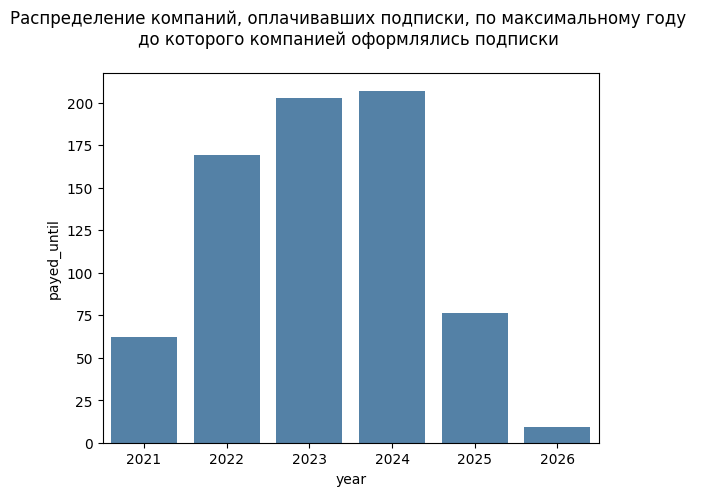

In [83]:
sns.barplot(
    data=(
        pd.to_datetime(
            billing[~(billing['pay_date'].isna())]
            .groupby('company_id')
            .agg({'payed_until' : 'max'})['payed_until']
        ).dt.year
        .value_counts()
        .to_frame()
        .reset_index()
        .sort_values(by='index')
        .rename(columns={
            'index' : 'year'
        })
    ),
    x='year',
    y='payed_until',
    color='steelblue'
)
plt.title('Распределение компаний, оплачивавших подписки, по максимальному году \n'+ \
          'до которого компанией оформлялись подписки \n');

В целом в распределении самой дальней даты в `payed_until` для оплаченных заказов между компаниями нет аномальных значений, поэтому не будем дополнительно производить чистку данных.

#### Датасет companies

На первом шаге было отмечено, что в датасете companies в столбце `updated_at` есть одно очень частое значение.

In [84]:
companies['updated_at'].value_counts().sort_values(ascending=False).head(5)

2022-12-06    178
2023-08-25      4
2023-09-01      4
2023-08-01      4
2024-03-06      4
Name: updated_at, dtype: int64

In [85]:
print(
    'Доля записей, обновленных 6.12.2022 года от всех записей датасета:',
    round(companies['updated_at'].value_counts().sort_values(ascending=False).head(1).squeeze() / len(companies_raw) * 100),
    '%'
)

Доля записей, обновленных 6.12.2022 года от всех записей датасета: 25 %


Самая частая дата - это 6 декабря 2022 года, в этот день были внесены изменения в более 209 записей (25% от всего исходного датасета). ***Необходимо уточнить у заказчика, по какой причине именно в этот день было внесено большое количество изменений в датасете.***

In [86]:
companies['is_strange_date'] = 0
companies.loc[companies['updated_at'] == pd.to_datetime('2022-12-06'), 'is_strange_date'] = 1

(
    companies
    .groupby('is_strange_date')
    .agg({
        'employer_count_interval' :  pd.Series.mode,
        'created_at' :  pd.Series.mode,
        'billing_tariff_id' :  pd.Series.mode,
        'billing_is_over' : 'mean'
    }
    )
)

employer_count_interval                created_at  \
is_strange_date                                                      
0                                      1                2022-04-07   
1                                      1  [2021-05-12, 2021-10-12]   

                 billing_tariff_id  billing_is_over  
is_strange_date                                      
0                              2.0         0.424623  
1                              2.0         0.988764

Можно заметить, что ***99% компаний, информация о которых последний раз обновлялась 6 декабря 2022 года, это компании с истекшей оплатой подписки***, то есть те, что перестали пользоваться приложением. Видно также, что в основном записи об этих компаниях были созданы раньше, чем для остальных компаний (в 2021 и 2020 году по сравнению с 2022 годом для компаний, где информация не обновлялась последний раз в эту дату). Возможно, в этот день производился мониторинг оплат подписок в базах данных и отмечались отточные компании.

Не будем производить никаких изменений, касаемо данной аномалии.

#### Датасет people

Убедимся, что все даты в people соответствуют действительности (нет записей из будущего).

In [87]:
for col in ['created_at', 'updated_at', 'deleted_at']:
    print('Для столбца', col, ':', 
          f"максимальная дата - {max(people.loc[~(people[col].isna()), col])},", 
          f"минимальная дата - {min(people.loc[~(people[col].isna()), col])}"
         )

Для столбца created_at : максимальная дата - 2023-12-13, минимальная дата - 2019-07-26
Для столбца updated_at : максимальная дата - 2023-12-13, минимальная дата - 2019-07-26
Для столбца deleted_at : максимальная дата - 2023-12-13, минимальная дата - 2019-08-13


Самые ранние даты записей относятся к 2019 году, хотя на предыдущих шагах были удалены компании, которые начали пользоваться приложением ранее ноября 2020 года. Видимо, некоторые "старые" пользователи приложения меняли компании или создавали новые компании, которые подключались к приложению позже.

### Преобразование датасетов

#### Подсчет количества подписок на компанию за всё время

Будем считать, что в датасете billing корректно указаны уникальные номера цены подписки, которой воспользовался клиент. Тогда предположим, что в случае оформления новой подписки (даже по предыдущему тарифу), изменяется id цены тарифа. Тогда можем посчитать количество уникальных подписок, оплаченных клиентом, как количество уникальных значений `billing_tariff_price_id` для компании за всё время.

In [88]:
len(companies)

576

In [89]:
companies = (
    companies
    .merge(
        (
            billing[~(billing['pay_date'].isna())]  # смотрим только записи с оплатами
            .groupby('company_id')
            .agg({
                'billing_tariff_price_id' : 'nunique'
            })
            .reset_index()
            .rename(columns={
                'billing_tariff_price_id' : 'count_of_payed_tariffs',
                'company_id' : 'id'
            })
        ),
        on = 'id'
    )
)

In [90]:
# проверим, что не потеряли компании в датасете
len(companies)

576

#### Группы направления деятельности компаний

Попробуем выделить самые распространенные направления деятельности компаний-клиентов.

In [91]:
companies['working_direction'].value_counts().head(15)

строительство                            58
малоэтажное строительство                 8
строительство и ремонт                    4
строительная компания                     3
строительство загородных домов            3
ремонт квартир                            3
строительство домов                       3
электромонтаж                             3
ремонт под ключ                           3
девелопмент                               3
ремонт                                    2
строительство коттеджей                   2
строительство зданий и сооружений         2
инженерные системы                        2
строительство инженерных коммуникаций     2
Name: working_direction, dtype: int64

Так как Компания в целом предоставляет сервис для строительных компаний, то логично, что самое популярное направление деятельности - просто строительство. Исходя из наблюдаемых уникальных значений, сгруппируем описание деятельности компаний по ключевым словам, выделив 7 групп:
* Строительно-ремонтная компания
* Строительство объектов недвижимости
* Строительно-монтажные работы
* Отделочные работы
* Энергетика
* Строительство
* Другое
* Не указано

In [92]:
# добавим столбец с группой 
companies['working_direction_group'] = companies['working_direction'].apply(work_group)

#### Добавление группы подписки

1, 18, 22 - тестовые, бесплатные и пробные; тарифы 4, 7, 8, 11, 19 - группа “старт”, тарифы 2, 17 - группа “базовый”, тарифы 9, 20 - группа “бизнес”, тарифы 3, 10, 13, 21 - группа “Профи”, тариф 6 - “архивный”, в настоящее время не используется.

In [93]:
billing['tariff_group'] = ''
billing.loc[billing['billing_tariff_id'].isin([1, 18, 22]), 'tariff_group'] = 'Пробный / Бесплатный / Тестовый'
billing.loc[billing['billing_tariff_id'].isin([4, 7, 8, 11, 19]), 'tariff_group'] = 'Старт'
billing.loc[billing['billing_tariff_id'].isin([2, 17]), 'tariff_group'] = 'Базовый'
billing.loc[billing['billing_tariff_id'].isin([9, 20]), 'tariff_group'] = 'Бизнес'
billing.loc[billing['billing_tariff_id'].isin([3, 10, 13, 21]), 'tariff_group'] = 'Профи'
billing.loc[billing['billing_tariff_id'].isin([6]), 'tariff_group'] = 'Архивный'

#### Отбор отточных компаний

Из имеющихся данных необходимо определить, по какому парамметру будем определять, является ли компания отточной или нет. Возможные способы: 
1. Сравнение даты завершения действия оплаченной подписки (по полю `payed_until` в billing) с датой проведения исследования.
2. Контроль даты последней активности компании (по датасету activities).

Контроль по полю `billing_is_over` не является достоверным вариантом, как было выяснено в ходе обсуждения с заказчиком.

В первом способе проводим оценку оплаты тарифа клиентом. Однако, в ходе предобработки и изучения данных о некоторых компаниях, в особенности, комментариев об оплатах тарифов, можно заметить, что некоторые компании замораживали оплату своего тарифа на длительные периоды, вплоть до года и, вероятно, дольше. Клиенты могли замораживать подписки, например, из-за отсутствия необходимого функционала на платформе, а затем активировать её обратно, когда необходимые функции появлялись. В данных при этом эта ситуация, во-первых, может быть раскрыта по-разному (как обновлением старой записи и добавлением комментариев, так появлением новой записи в датасете). Во-вторых, для некоторых компаний на момент анализа мог ещё не наступить этап разморозки (она ещё не отточная, но находится в ожидании и не использует подписку), тогда такие компании будут.

Второй способ позволил бы выявить также потенциально отточные или компании, фактически не использующие функционал платформы. Но чтобы наиболее эффективно использовать этот метод, необходимо оценить в целом частоту использования компаниями отдельных функций, а также определить, с какого момента считаем, что компания перестала пользоваться приложением.

***В рамках этого исследования воспользуемся определеннием отточных компаний именно по первому способу. Однако добавим информацию о перерывах в активности компаний в activities для дальнейшего исследования.***

In [94]:
# выделим день анализа
current_day = pd.to_datetime('28.03.2024').date()

In [95]:
# найдём отточные компании
churn_cids = (
    billing
    .groupby('company_id')
    .agg({
        'payed_until' : 'max'
    })
)
churn_cids['delta'] = churn_cids['payed_until'] - current_day
churn_cids = churn_cids[churn_cids['delta'] <=  pd.Timedelta('0 days')]

display(churn_cids.head())
print('Количество отточных компаний:', len(churn_cids))

payed_until     delta
company_id                      
11          2023-06-30 -272 days
383         2024-03-16  -12 days
421         2022-05-31 -667 days
615         2022-02-12 -775 days
622         2024-02-22  -35 days

Количество отточных компаний: 452


In [96]:
# добавим метки отточных компаний в датасеты companies и billing
# добавляем в оба датасета, т.к. в companies есть не все компании, которые есть в billing
companies['churn_flag'] = 0
companies.loc[companies['id'].isin(churn_cids.index), 'churn_flag'] = 1

billing['churn_flag'] = 0
billing.loc[billing['company_id'].isin(churn_cids.index), 'churn_flag'] = 1

Для каждой компании расчитаем среднюю длительность перерывов в активности по датасету activities, добавим эту информацию в новый столбец датасета `median_delay_in_months`.

In [97]:
count_delays(activities)

Посмотрим на разброс значений для разных расчетов:


mean_delay_per_company  median_delay_per_company  max_delay_per_company
count              562.000000                562.000000             562.000000
mean                 2.008803                  1.621231               4.286276
std                  2.311483                  2.191072               5.449761
min                  0.919937                  0.919937               0.919937
25%                  1.002074                  1.018501               1.018501
50%                  1.182776                  1.018501               2.004148
75%                  1.971293                  1.018501               5.026797
max                 21.059981                 21.059981              33.019159

In [98]:
activities.head()

company_id       month  billing  stocks  backups  projects  contractors  \
63         383  2022-12-01      1.0     0.0      0.0       1.0          0.0   
64         383  2023-02-01      1.0     4.0      0.0       4.0          3.0   
65         408  2022-11-01      1.0     1.0      0.0       1.0          1.0   
66         408  2022-12-01      1.0     0.0      0.0       0.0          0.0   
68         421  2020-09-01      1.0     0.0      0.0       0.0          0.0   

    resource_orders  median_delay_in_months  
63              0.0                     8.0  
64              0.0                     8.0  
65              0.0                     1.0  
66              0.0                     1.0  
68              0.0                     1.0

Расчет произведен успешно.

#### Кодировка категориальных признаков

In [99]:
billing_tariff_id_data = get_dum(billing, 'billing_tariff_id')
billing_tariff_price_id_data = get_dum(billing, 'billing_tariff_price_id')
billing_tariff_group_data = get_dum(billing, 'tariff_group')

billing['comment_flag'] = 0
billing.loc[~(billing['comment'].isna()), 'comment_flag'] = 1

billing = billing.join([billing_tariff_id_data, billing_tariff_price_id_data, billing_tariff_group_data])

In [100]:
companies_working_direction_group_data = get_dum(companies, 'working_direction_group')
companies = companies.join(companies_working_direction_group_data)

### Итоги предобработки

In [101]:
# подсчитаем долю удаленных данных по всем датасетам
print('Доля от исходных данных датасета activities:', f"{len(activities) / len(activities_raw):.2%}")
print('Доля от исходных данных датасета billing:', f"{len(billing) / len(billing_raw):.2%}")
print('Доля от исходных данных датасета companies:', f"{len(companies) / len(companies_raw):.2%}")
print('Доля от исходных данных датасета people:', f"{len(people) / len(people_raw):.2%}")

Доля от исходных данных датасета activities: 79.43%
Доля от исходных данных датасета billing: 44.91%
Доля от исходных данных датасета companies: 79.67%
Доля от исходных данных датасета people: 82.77%


<font size="4">В ходе предобработки было отмечено следующее:</font>
1. Опеделено, что в датасете people значение столбца `is_deleted` связано с удалением сотрудника из проекта компании, а не удалением пользователя из приложения.
2. В данном исследовании будем считать, что ***если в столбце `pay_date` указана дата, то подписка была оплачена***. Если дата не указана, а в `is_payed` стоит True, то считаем, что клиент воспользовался бесплатным периодом подписки, но далее платить не стал.
3. Если проект открыт и сотрудники-исполнители данного проекта компании не удалены из этого проекта, то ***90% этих сотрудников по крайней мере принимают приглашения и регистрируются в приложении.***
4. Среди клиентов есть компании, замораживавшие свои подписки на разный срок.
5. ***Практически все компании, информация о которых последний раз обновлялась 6 декабря 2022 года, это компании с истекшей оплатой подписки*** (согласно столбцу billing_is_over), то есть те, что перестали пользоваться приложением.
6. ***В рамках данного исследования решено считать отточными те компании, у которых дата окончания оплаченной подписки наступила ранее даты исследования (дата исследования: 28.03.2024).***

<font size="4">Необходимо уточнить у заказчика:</font>

1. Возможные причины появления в billing строчек с двумя одновременно пустыми столбцами `is_payed` и `pay_date`.
2. Причины отсутствия информации о некоторых компаниях (есть данные о платежах этих компаний в billing, но нет информации в остальных датасетах).
3. Когда был введен данный способ хранения и обновления информации?
4. Как можно дополнительно проверить достоверность записей, созданных в 2019 году? (В данных за этот год нет ни одной записи без пропусков в дате оплаты).
5. 6 декабря 2022 года были внесены изменения в большое количество записей (почти 30% от исходного датасета companies), почему столько изменений было внесено в эту дату и с чем они были связаны?
6. Чем отличаются id тарифов внутри одной группы тарифа?

## Исследовательский анализ данных

### Общая информация о клиентах компании

In [102]:
print('Общее количество компаний:', len(billing['company_id'].unique()))
print('Количество компаний, о которых есть информация только в billing:', len(extra_cids),
     f"({(len(extra_cids) / len(billing['company_id'].unique())):.1%})")
print('Количество отточных компаний:', len(churn_cids),
     f"({(len(churn_cids) / len(billing['company_id'].unique())):.1%})")
print('Количество компаний, информация о которых обновлялась 6 декабря 2022 года:',
     len(companies[companies['is_strange_date'] == 1]),
     f"({(len(companies[companies['is_strange_date'] == 1]) / len(billing['company_id'].unique())):.1%})")

Общее количество компаний: 726
Количество компаний, о которых есть информация только в billing: 154 (21.2%)
Количество отточных компаний: 452 (62.3%)
Количество компаний, информация о которых обновлялась 6 декабря 2022 года: 178 (24.5%)


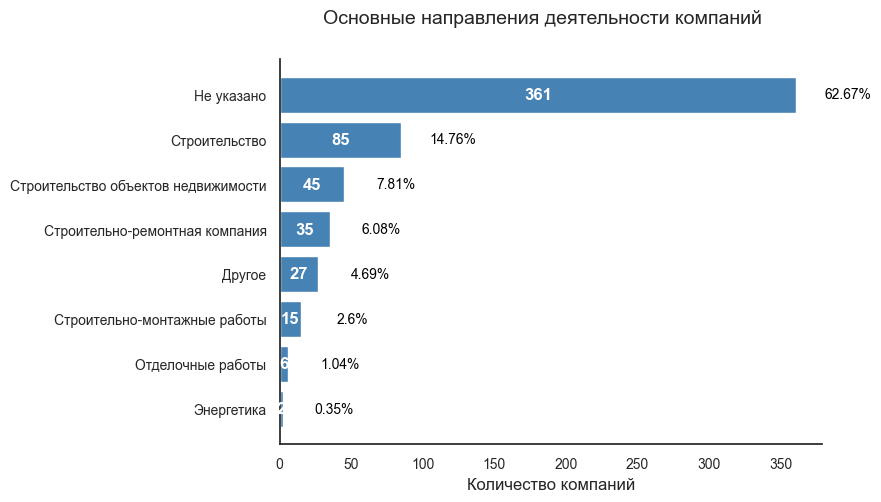

In [103]:
fig_barh('Основные направления деятельности компаний',
         14, (7, 5),
         companies.groupby('working_direction_group')['id'].agg('count').sort_values().index,
         companies.groupby('working_direction_group')['id'].agg('count').sort_values(),
         'Количество компаний',
        (1/2), True, True)

Данные группы направлений деятельности компаний сформированы вручную в ходе предобработки данных.

У 63% компаний направление деятельности не указано. Это поле заполняется вручную пользователями приложения при оформлении аккаунта / создании проекта. В поле можно указывать текстовое значение свободной формы (обычным вводом текста), по этой причине в данных наблюдается большое количество схожих (но фактически разных) значений, в том числе с орфографическими ошибками и т.д. 

В целом, все клиенты работают в сфере строительства (Компания создаёт продукт целенаправленно для строительных компаний), поэтому не удивительно, что большинство имеющихся значений (из указанных) подразумевают просто "Строительство", ***однако полезной информации данное значение не несёт.*** *Чтобы поле потенциально давало больше информации, можно* ***предложить не свободный ввод категории,*** *а, например, множественный выбор из конкретных категорий, при этом оставить в предлагаемых значениях поле "Другое" с последующим свободным вводом значений, чтобы отслеживать компании, которые не войдут в предложенную классификацию.*

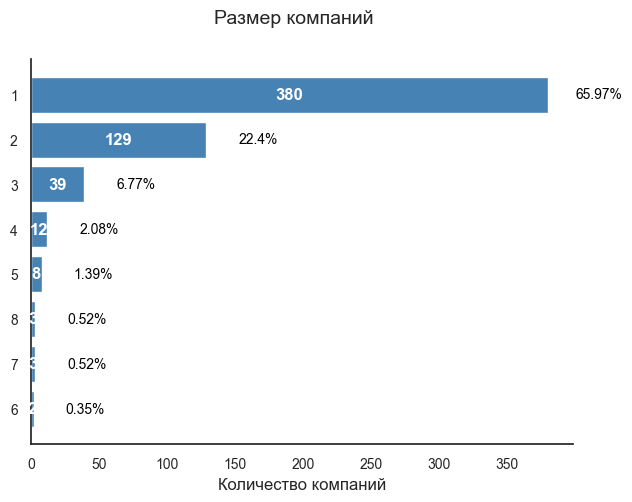

In [104]:
fig_barh('Размер компаний',
         14, (7, 5),
         companies.groupby('employer_count_interval')['id'].agg('count').sort_values().index.astype('str'),
         companies.groupby('employer_count_interval')['id'].agg('count').sort_values().values,
         'Количество компаний',
        (1/2), True, True)

***Большая часть клиентов (~66%) - это маленькие компании, состоящие из не более, чем 3-х сотрудников.*** Средние и крупные компании (с количеством сотрудников более 20) составляют менее 5% от всех клиентов за всё время.

In [105]:
new_companies_graph()

***В 2023 году количество новых компаний снизилось.*** В предыдущие года пиковые значения количества новых пользователей в месяц приходились на май, для 2023 года можно заметить провал в этот же период времени. На момент начала 2024 года количество новых пользователей в месяц только снижается. Возможно, изменилась маркетинговая политика приложения.

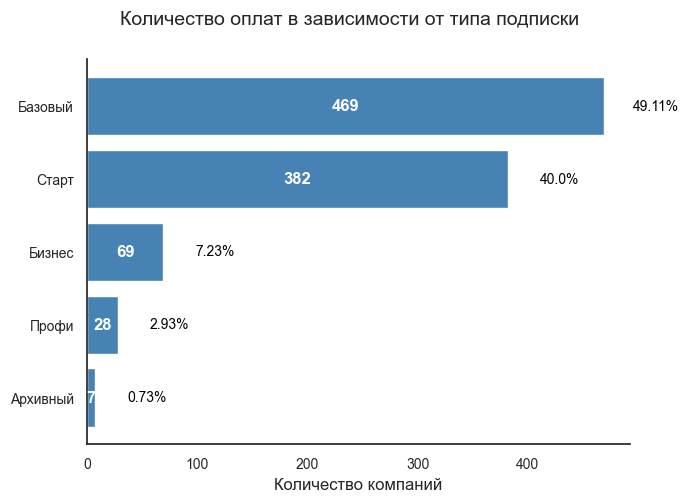

In [106]:
fig_barh('Количество оплат в зависимости от типа подписки',
         14, (7, 5),
         (
             billing[~(billing['pay_date'].isna())]
             .groupby('tariff_group')['company_id']
             .agg('count')
             .sort_values()
             .index
         ),
         (
             billing[~(billing['pay_date'].isna())]
             .groupby('tariff_group')['company_id']
             .agg('count')
             .sort_values()
         ),
         'Количество компаний',
        (1/2), True, True)

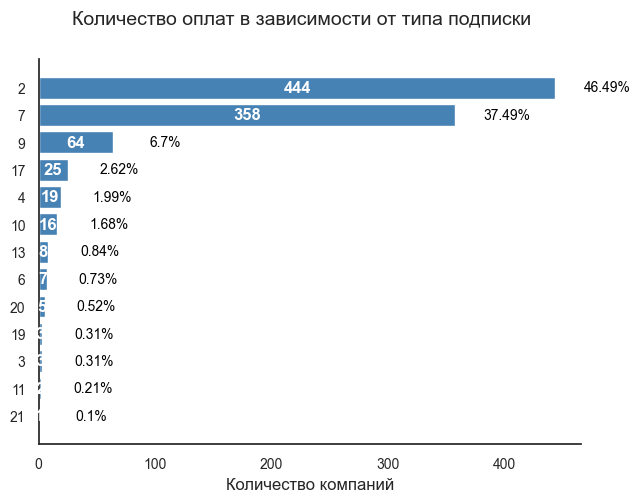

In [107]:
fig_barh('Количество оплат в зависимости от типа подписки',
         14, (7, 5),
         (
             billing[~(billing['pay_date'].isna())]
             .groupby('billing_tariff_id')['company_id']
             .agg('count')
             .sort_values()
             .index
             .astype('str')
         ),
         (
             billing[~(billing['pay_date'].isna())]
             .groupby('billing_tariff_id')['company_id']
             .agg('count')
             .sort_values()
             .values
         ),
         'Количество компаний',
        (1/2), True, True)

***Клиенты в основном задействуют тарифы "Базовый" и "Старт"*** (чаще всего за рассматриваемый промежуток времени оформляли подписки с id 2 и 7).

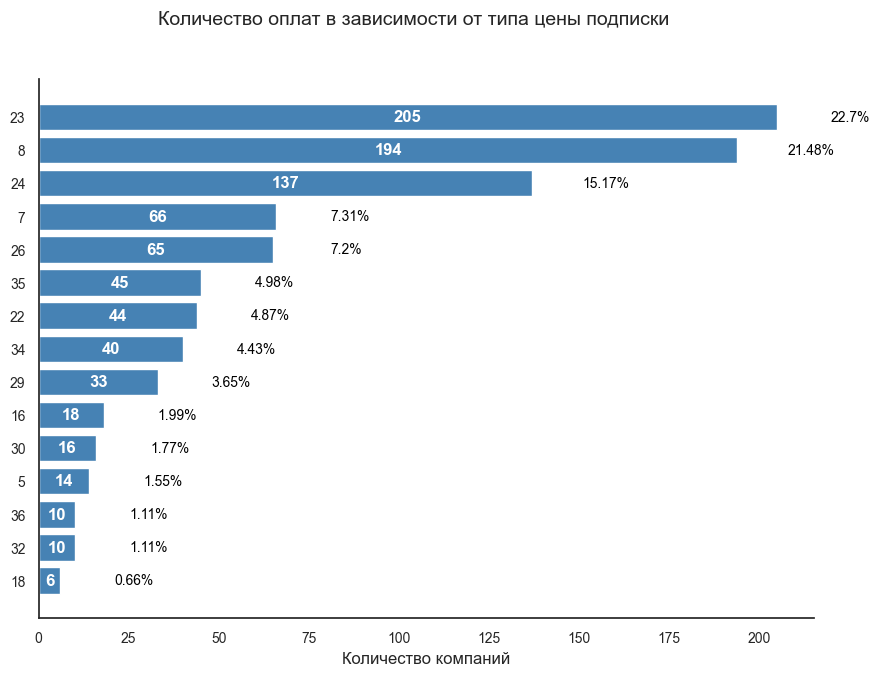

In [108]:
fig_barh('Количество оплат в зависимости от типа цены подписки',
         14, (10, 7),
         (
             billing[~(billing['pay_date'].isna())]
             .groupby('billing_tariff_price_id')['company_id']
             .agg('count')
             .sort_values()
             .tail(15)
             .index
             .astype('str')
         ),
         (
             billing[~(billing['pay_date'].isna())]
             .groupby('billing_tariff_price_id')['company_id']
             .agg('count')
             .sort_values()
             .tail(15)
             .values
         ),
         'Количество компаний',
        (1/2), True, True)

Больше всего оплат по ценам с id 23, 8, 24.

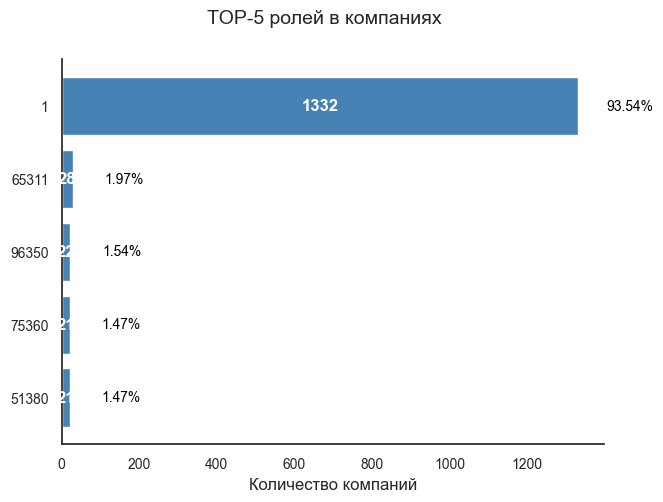

In [109]:
fig_barh('TOP-5 ролей в компаниях',
         14, (7, 5),
         (
             people
             .groupby('role_id')['id']
             .agg('count')
             .sort_values()
             .tail(5)
             .index
             .astype('str')
         ),
         (
             people
             .groupby('role_id')['id']
             .agg('count')
             .sort_values()
             .tail(5)
             .values
         ),
         'Количество компаний',
        (1/2), True, True)

В основном (94%) приложением пользуются люди, чья роль в компании скрывается под индексом 1. Посмотрим на ТОР-3 популярные роли в зависимости от размера компании.

In [111]:
# для каждого размера компании посчитаем
# top-3 роли сотруднов в компании

top_roles = []
company_and_people_joined=(
        people
        .merge(
            companies.rename(columns={'id' : 'company_id'})[['company_id', 'employer_count_interval']],
            on='company_id'
        )
)

for csize in company_and_people_joined['employer_count_interval'].unique():
    top_roles.extend(
        company_and_people_joined.loc[company_and_people_joined['employer_count_interval'] == csize, 'role_id']
        .value_counts()
        .head(3)
        .index
    )
    

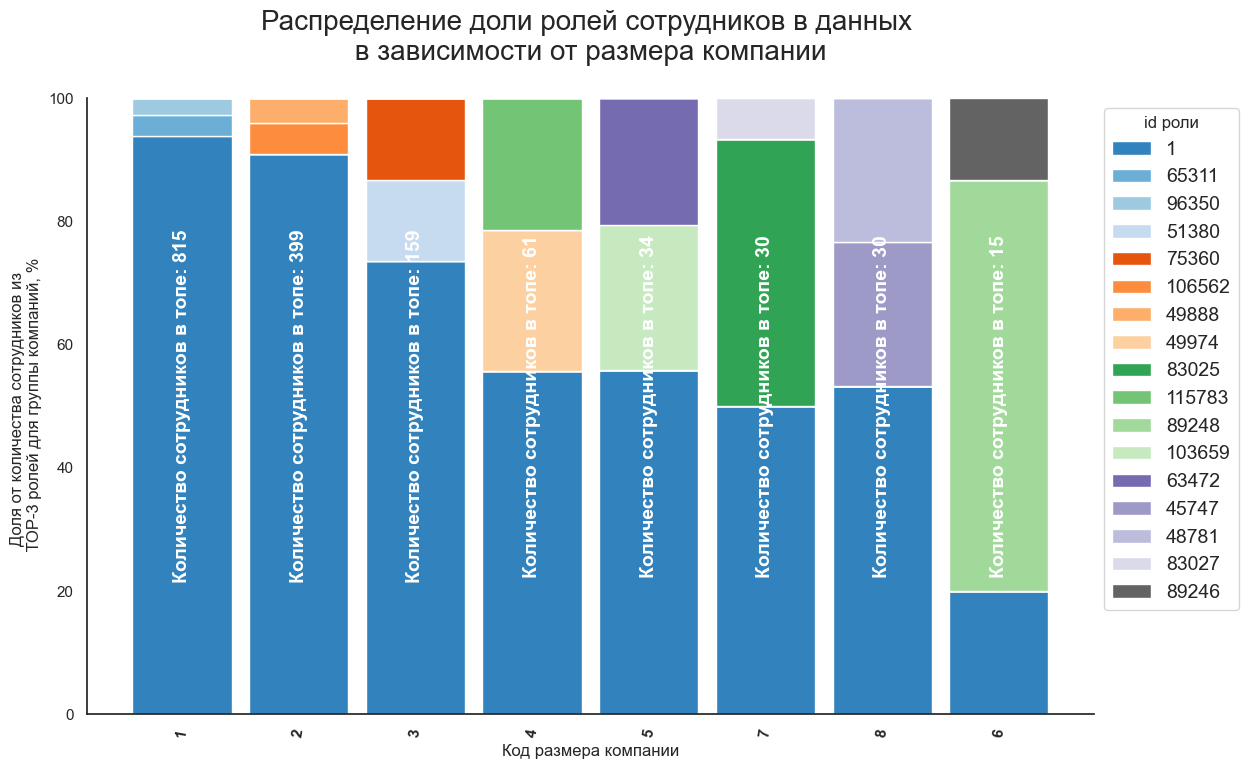

In [113]:
role_for_csize_plot(
    company_and_people_joined[company_and_people_joined['role_id'].isin(top_roles)], 
    'employer_count_interval', title='Распределение доли ролей сотрудников в данных \n в зависимости от размера компании \n'
)

Только для самых маленьких компаний роль id=1 относится к более половины сотрудников компании. В остальных случаях распределение ролей не однозначно, конкретной зависимости не выявить. Сильнее всего отличается ситуация для компаний размером 51-100 человек, среди них больше всего сотрудников с id 103659, однако важно помнить, что всего в датасете компаний данного размера только две.

Таким образом, оценить, насколько сильно отличаются наблюдаемые закономерности, сложно, т.к. нельзя сравнить, насколько близки по смыслу должности указанных id ролей, кроме того, количество компаний среднего и большого размера в целом мало. 

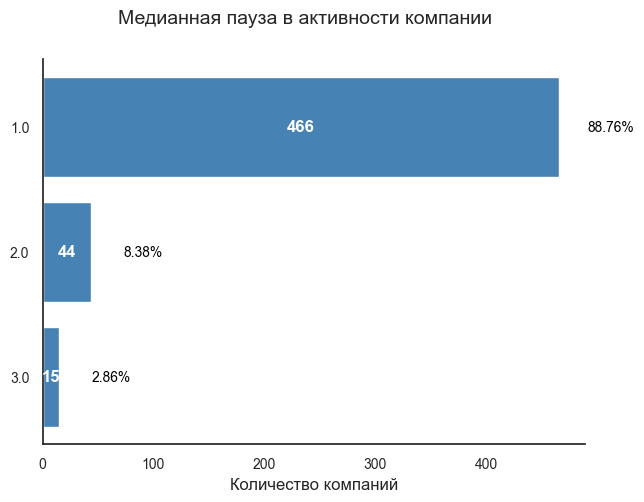

In [114]:
# Изучим активность компаний
fig_barh('Медианная пауза в активности компании',
         14, (7, 5),
         (
             activities
             .groupby('company_id')
             .agg({'median_delay_in_months' : 'max'})
             .reset_index()
             .groupby('median_delay_in_months')['company_id']
             .agg('count')
             .sort_values()
             .tail(3)
             .index
             .astype('str')
         ),
         (
             activities
             .groupby('company_id')
             .agg({'median_delay_in_months' : 'max'})
             .reset_index()
             .groupby('median_delay_in_months')['company_id']
             .agg('count')
             .sort_values()
             .tail(3)
             .values
         ),
         'Количество компаний',
        (1/2), True, True)

Около 89% компаний регулярно пользуются приложением. Посмотрим на характерные времена перерывов среди компаний, которые редко пользуются приложением.

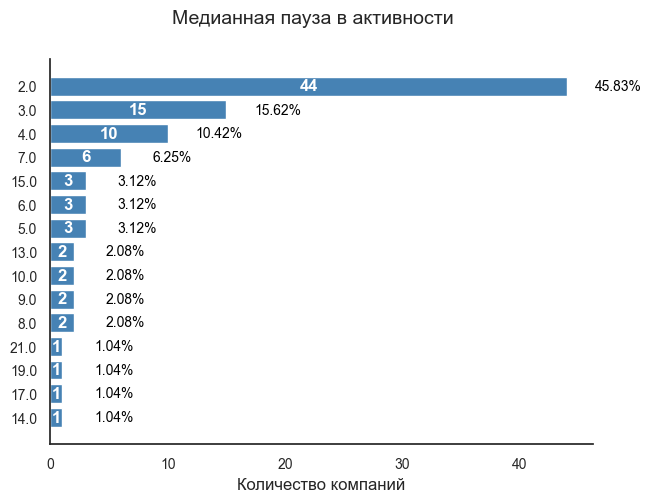

In [115]:
# Изучим активность компаний

fig_barh('Медианная пауза в активности',
         14, (7, 5),
         (
             activities[activities['median_delay_in_months'] > 1]
             .groupby('company_id')
             .agg({'median_delay_in_months' : 'max'})
             .reset_index()
             .groupby('median_delay_in_months')['company_id']
             .agg('count')
             .sort_values()
             .index
             .astype('str')
         ),
         (
             activities[activities['median_delay_in_months'] > 1]
             .groupby('company_id')
             .agg({'median_delay_in_months' : 'max'})
             .reset_index()
             .groupby('median_delay_in_months')['company_id']
             .agg('count')
             .sort_values()
             .values
         ),
         'Количество компаний',
        (1/2), True, True)

В некоторых случаях перерыв может составлять более, чем год.

### Исследование оттока

Посмотрим на долю отточных клиентов как в целом по всем данным, так и внутри отдельных групп.

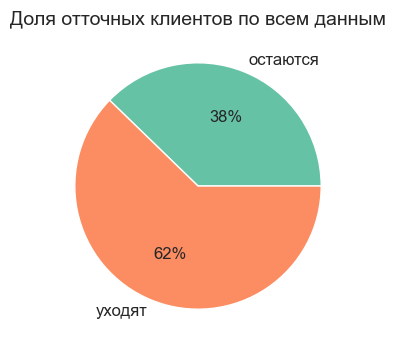

In [116]:
fig, ax = plt.subplots(figsize=(4,4))
plot_pie(
    (
        billing
        .groupby('company_id')
        .agg({
            'id' : 'count',
            'churn_flag' : 'max'
        })
    ),
    'churn_flag', labels=["остаются", 'уходят'])
plt.title('Доля отточных клиентов по всем данным', fontsize=14);

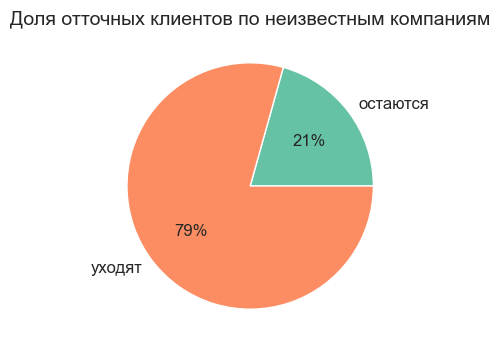

In [117]:
fig, ax = plt.subplots(figsize=(4,4))
plot_pie(
    (
        billing[billing['company_id'].isin(extra_cids)]
        .groupby('company_id')
        .agg({
            'id' : 'count',
            'churn_flag' : 'max'
        })
    ),
    'churn_flag', labels=["остаются", 'уходят'])
plt.title('Доля отточных клиентов по неизвестным компаниям', fontsize=14);

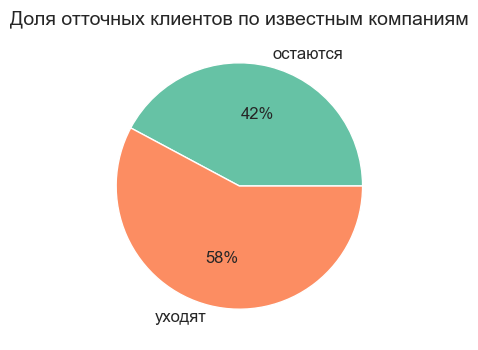

In [118]:
fig, ax = plt.subplots(figsize=(4,4))
plot_pie(companies, 'churn_flag', labels=["остаются", 'уходят'])
plt.title('Доля отточных клиентов по известным компаниям', fontsize=14);

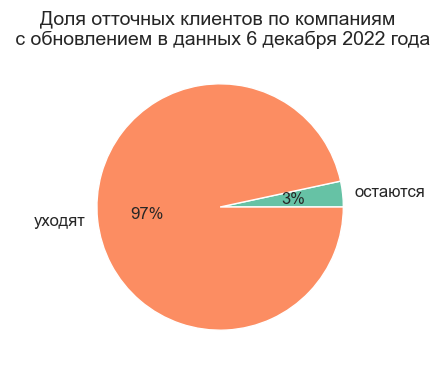

In [119]:
fig, ax = plt.subplots(figsize=(4,4))
plot_pie(companies[companies['is_strange_date'] == 1], 'churn_flag', labels=["остаются", 'уходят'])
plt.title('Доля отточных клиентов по компаниям \n с обновлением в данных 6 декабря 2022 года', fontsize=14);

***Доля отточных компаний по всему датасету составляет 62%.*** Если рассматривать компании в разрезе количества имеющейся о нех информации, то ***доля отточных в группе неизвестных компаний выше:*** 79% против 58%. Кроме того, при исследовании оттока имеет смысл обратить внимание на группу компаний, информация о которых обновлялась 6 декабря 2022 года, 97% этих компаниий перестали пользоваться продуктом.

In [120]:
# посмотрим, когда отточные компании были зарегистрированы
churn_company_dynamics()

Доля отточных компаний со временем снижается.

### Корреляционный анализ

#### По записям в billing

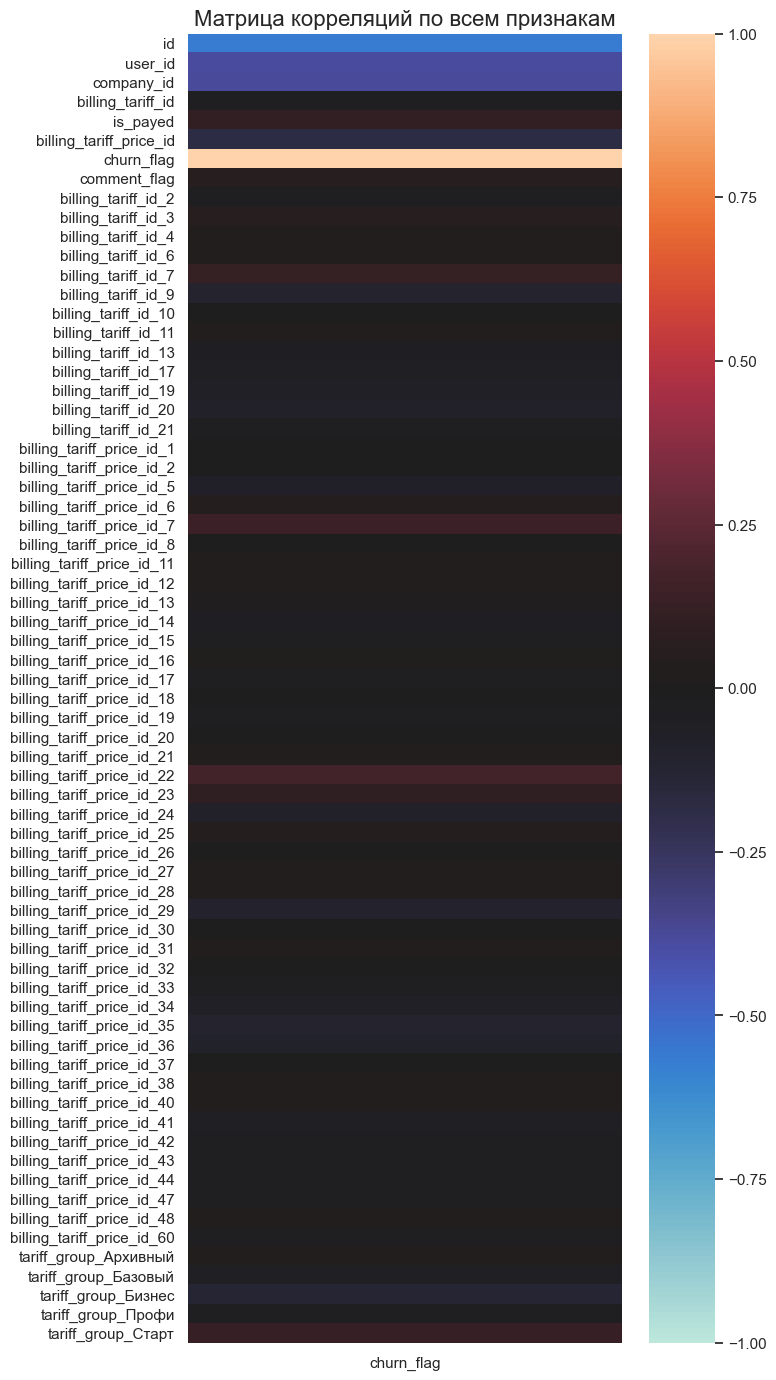

In [121]:
# посмотрим матрицу корреляции для всего датасета
matr_corr(billing, billing.columns, 'Матрица корреляций по всем признакам', False, (7,17), cols_show = ['churn_flag'])

По таблице billing больше всего связь корреляция наблюдается с фактом использования тарифов 7 и 9, также фактом цен с id 7, 22, 29, 35, 36, а также группой тарифов Бизнес и Старт.

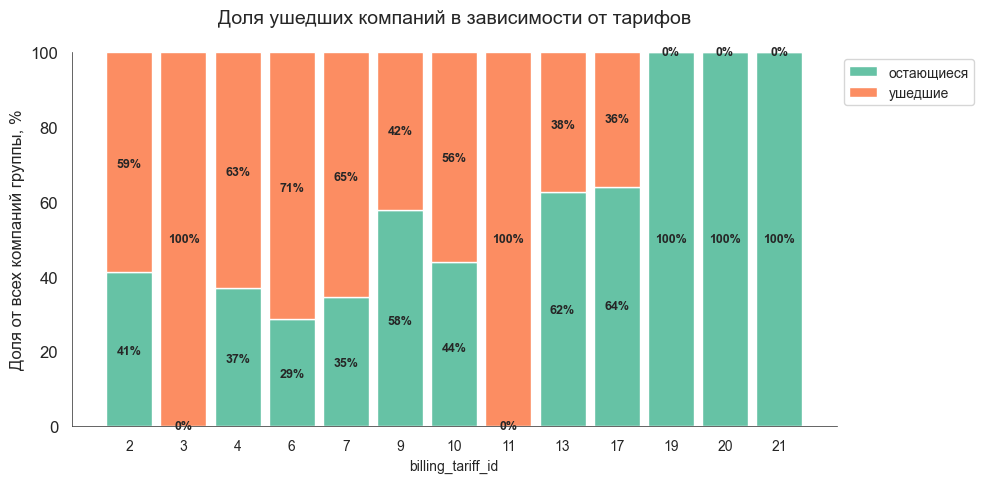

In [122]:
# посмотрим на долю отточных в зависимости от оплаченного тарифа
ratio_per_category(billing[~(billing['pay_date'].isna())], 'billing_tariff_id', 'churn_flag', 
                   title_part=' в зависимости от тарифов', figsize=(10, 5)
                  )

1. Все компании, которые когда-либо оплачивали тарифы 3 и 11, перестали пользоваться приложением. Однако оплат по этим тарифам составляет всего 3 и 2 соответственно.
2. Среди пользователей тарифов 19, 20, 21 нет отточных, но в сумме этими тарифами пользуется всего 9 компаний.
3. ***Среди самых популярных тарифов (2, 7, 9) самый высокий отток у тарифа 9*** *(относится к группе "Бизнес"):* ***58%.***


In [123]:
billing[billing['tariff_group'] == 'Бизнес']['billing_tariff_price_id'].unique()

array([28, 29, 36, 30, 18, 19, 47, 38])

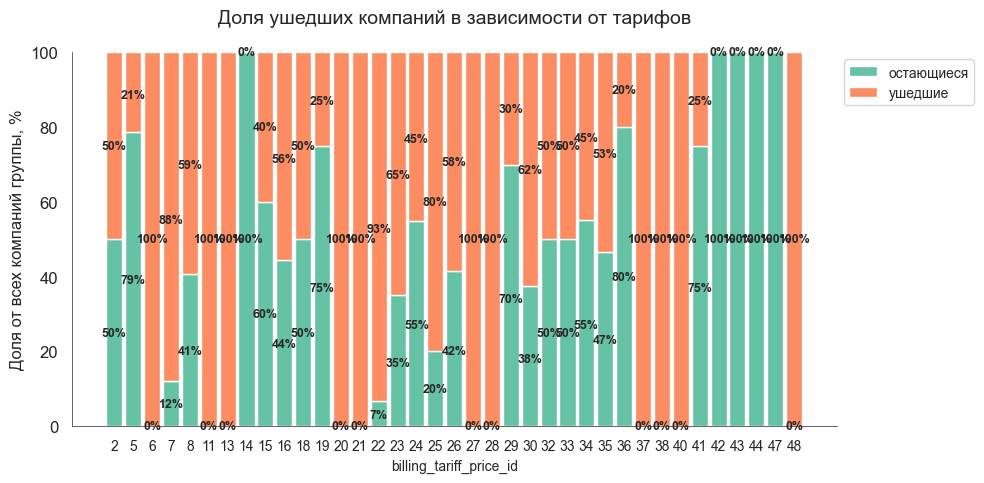

In [124]:
# посмотрим на долю отточных в зависимости от оплаченного тарифа по записям
ratio_per_category(billing[~(billing['pay_date'].isna())], 'billing_tariff_price_id', 'churn_flag', 
                   title_part=' в зависимости от тарифов', figsize=(10, 5)
                  )

4. Доля отточных для самых популярных подписок (23, 8, 24): 65%, 59% и 45% соответственно.
5. Самая высокая доля отточных для тарифа с ценой 7 (88%), 22 (93%).
6. Есть тарифы, для которых отток 100% или наоборот отсутствует, однако количество записей по данным тарифам низкое.

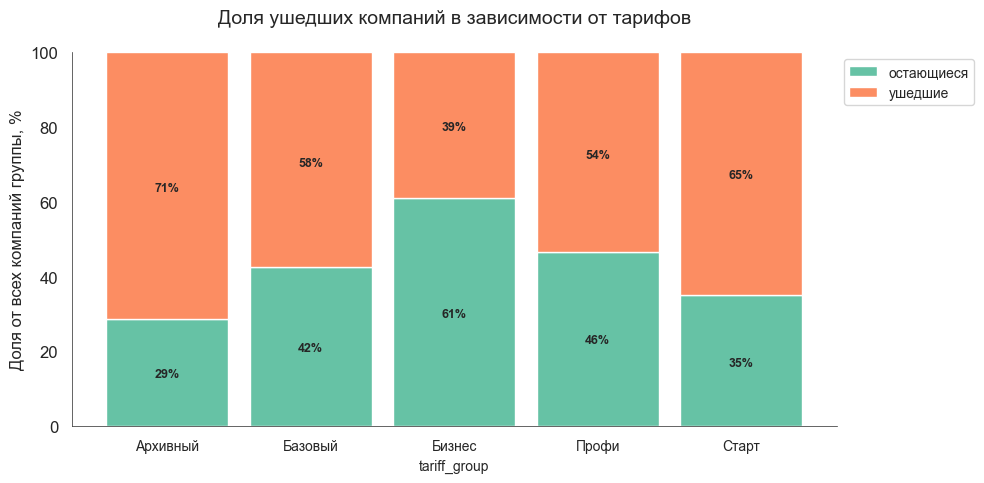

In [125]:
# посмотрим на долю отточных в зависимости от оплаченного тарифа по записям
ratio_per_category(billing[~(billing['pay_date'].isna())], 'tariff_group', 'churn_flag', 
                   title_part=' в зависимости от тарифов', figsize=(10, 5)
                  )

7. По группам тарифов, самый высокий отток по тарифу "Бизнес" - 61%.
8. Самая низкая доля у архивного тарифа, но им пользовалось только 7 компаний.

#### По записям в companies

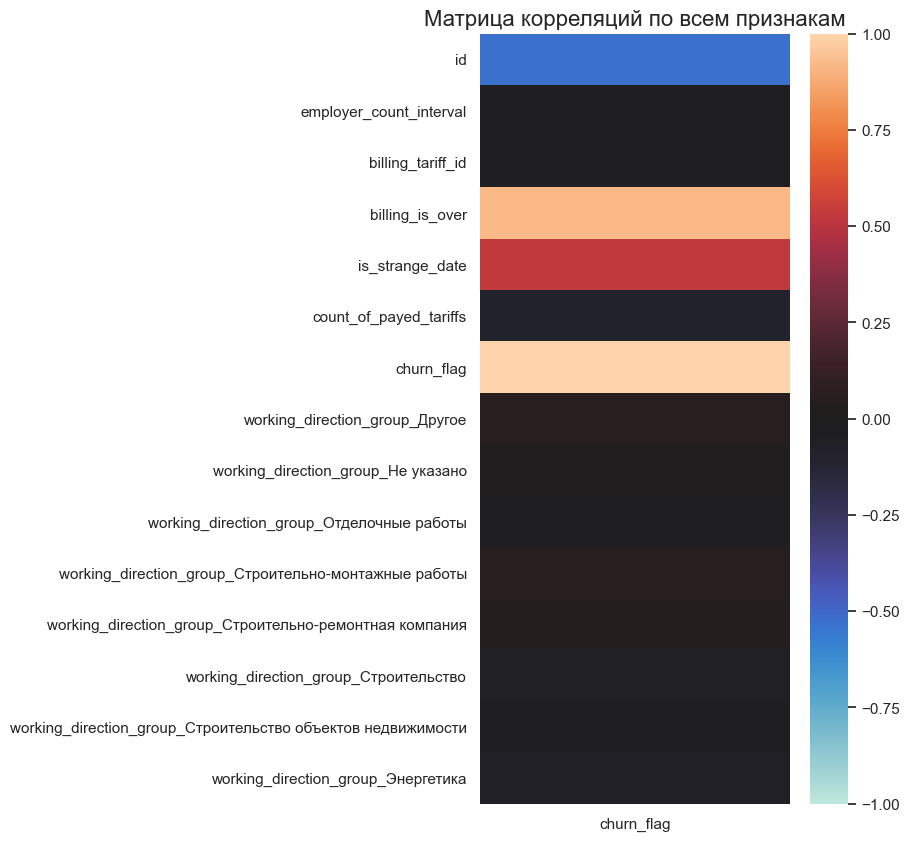

In [126]:
# посмотрим матрицу корреляции для всего датасета
matr_corr(companies, companies.columns, 'Матрица корреляций по всем признакам', False, (5,10), cols_show = ['churn_flag'])

Сильных корреляций не наблюдается.

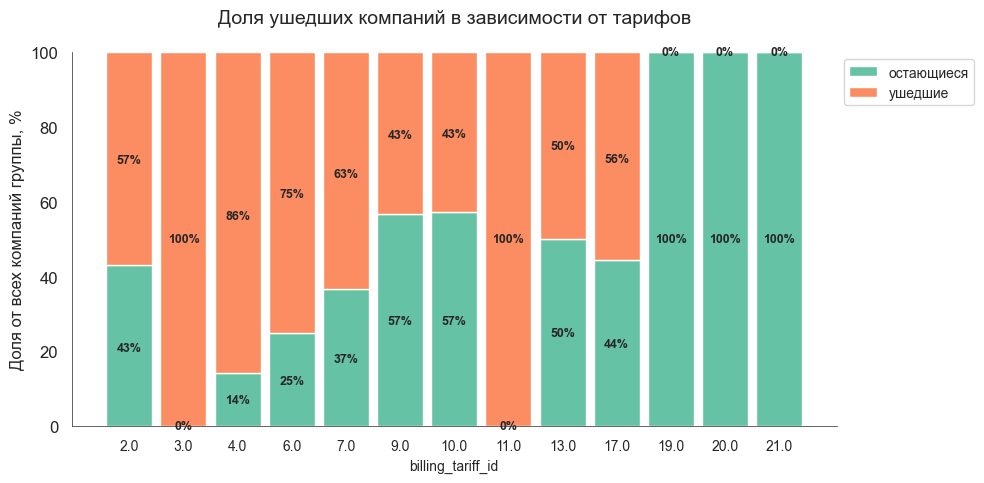

In [127]:
# посмотрим на долю отточных в зависимости от оплаченного тарифа
ratio_per_category(companies, 'billing_tariff_id', 'churn_flag', 'id', 
                   title_part=' в зависимости от тарифов', figsize=(10, 5)
                  )

9. Среди известных компаний, зависимость оттока от тарифа отличается в некоторых случаях:
    - отток для тарифа 4 ниже (14% против 37%)
    - отток для тарифа 10 выше (57% против 44%)
    - отток для тарифов 13 и 17 также ниже (50% и 44% против 62% и 64%)

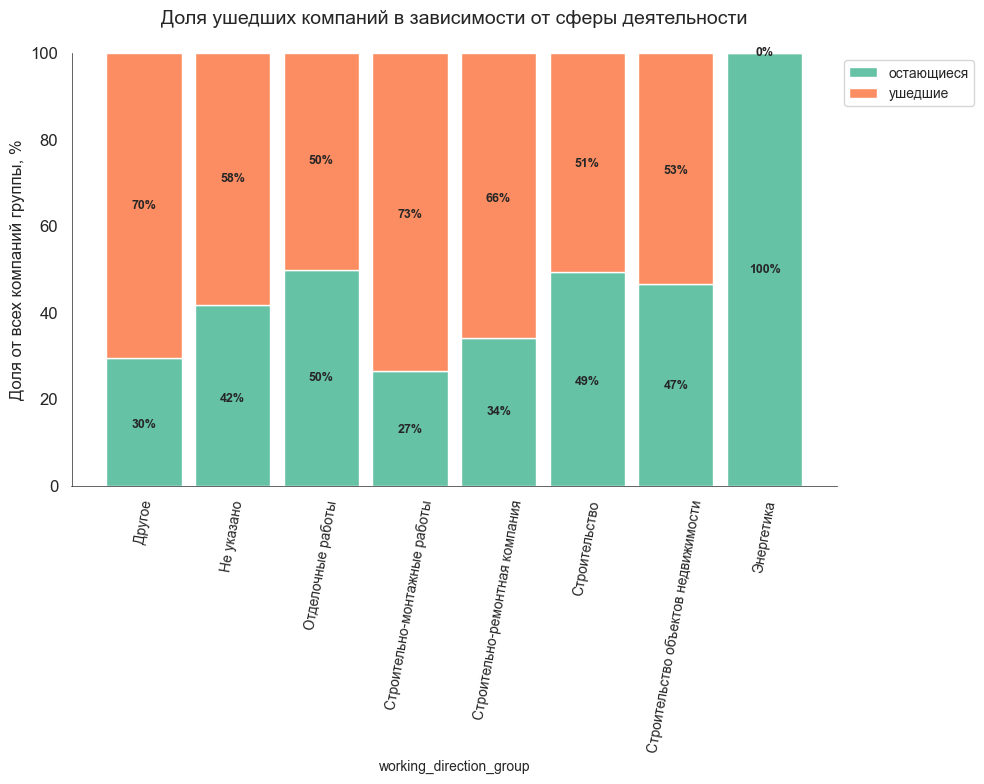

In [128]:
# посмотрим на долю отточных в зависимости от оплаченного тарифа
ratio_per_category(companies, 'working_direction_group', 'churn_flag', 'id', 
                   title_part=' в зависимости от сферы деятельности', figsize=(10, 8), rot=80
                  )

10. В разрезе направления деятельности компании, самый низкий отток компаний, относящихся к энергетике: 0%. Компаний, относящихся к этой группе, только 3.
11. ***Самый высокий отток среди компаний, относящихся к группам Строительно-монтажные работы (73%), Другое (70%), Строительно-ремонтные компании (66%).***

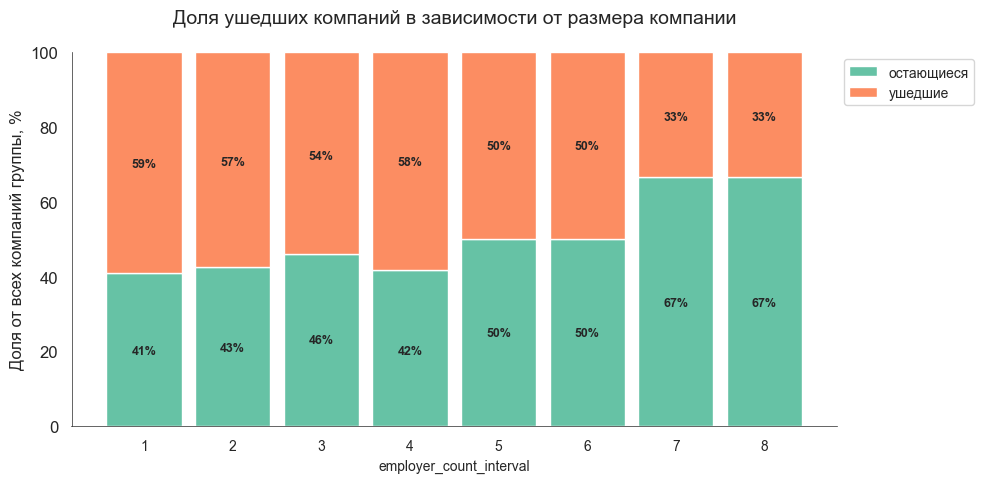

In [129]:
# посмотрим на долю отточных в зависимости от оплаченного тарифа
ratio_per_category(companies, 'employer_count_interval', 'churn_flag', 'id', 
                   title_part=' в зависимости от размера компании', figsize=(10, 5)
                  )

12. Повышенный отток у крупных компаний, однако в датасете их всего 6 штук.

## Выводы и рекомендации

### Выводы исследовательского анализа

1. ***Большая часть клиентов (~66%) - это маленькие компании, состоящие из не более, чем 3-х сотрудников.*** Средние и крупные компании (с количеством сотрудников более 20) составляют менее 5% от всех клиентов за всё время.
2. ***В 2023 году количество новых компаний снизилось.*** В предыдущие года пиковые значения количества новых пользователей в месяц приходились на май, для 2023 года можно заметить провал в этот же период времени. На момент начала 2024 года количество новых пользователей в месяц только снижается. Возможно, изменилась маркетинговая политика приложения.
3. ***Клиенты в основном задействуют тарифы "Базовый" и "Старт"*** (чаще всего за рассматриваемый промежуток времени оформляли подписки с id 2 и 7). ***Доля отточных компаний по всему датасету составляет 62%.*** 
4. Если рассматривать компании в разрезе количества имеющейся о нех информации, то ***доля отточных в группе неизвестных компаний выше:*** 79% против 58%. Кроме того, при исследовании оттока имеет смысл обратить внимание на группу компаний, информация о которых обновлялась 6 декабря 2022 года, 97% этих компаниий перестали пользоваться продуктом.1. Все компании, которые когда-либо оплачивали тарифы 3 и 11, перестали пользоваться приложением. Однако оплат по этим тарифам составляет всего 3 и 2 соответственно.
5. Среди пользователей тарифов 19, 20, 21 нет отточных, но в сумме этими тарифами пользуется всего 9 компаний.
6. ***Среди самых популярных тарифов (2, 7, 9) самый высокий отток у тарифа 9*** *(относится к группе "Бизнес"):* ***58%.***
7. Доля отточных для самых популярных подписок (23, 8, 24): 65%, 59% и 45% соответственно.
8. Самая высокая доля отточных для тарифа с ценой 7 (88%), 22 (93%).
9. Есть тарифы, для которых отток 100% или наоборот отсутствует, однако количество записей по данным тарифам низкое.7. По группам тарифов, самый высокий отток по тарифу "Бизнес" - 61%.
10. Самая низкая доля у архивного тарифа, но им пользовалось только 7 компаний.9. Среди известных компаний, зависимость оттока от тарифа отличается в некоторых случаях:
    - отток для тарифа 4 ниже (14% против 37%)
    - отток для тарифа 10 выше (57% против 44%)
    - отток для тарифов 13 и 17 также ниже (50% и 44% против 62% и 64%)
11. В разрезе направления деятельности компании, самый низкий отток компаний, относящихся к энергетике: 0%. Компаний, относящихся к этой группе, только 3.
12. ***Самый высокий отток среди компаний, относящихся к группам Строительно-монтажные работы (73%), Другое (70%), Строительно-ремонтные компании (66%).***12. Повышенный отток у крупных компаний, однако в датасете их всего 6 штук.

### Выводы и рекомендации касаемо оттока

Основная масса отточных компаний - это старые клиенты, которые взаимодействовали со старой версией продукта. Вероятно, клиентам не хватало представленного на тот момент в приложении функционала. Общая доля оттока при этом остаётся высокой, так как абсолютное количество клиентов, появившихся в 2023 году заметно ниже, чем количество клиентов, регистрировавшихся ранее.

В разрезе остальных характеристик, высокий отток наблюдается у группы "Бизнес", для данной группы необходимо обратить внимание на компании, оплачивавшие тариф согласно цене тарифа с id=30 и на компании, пользовавшиеся тарифом 9.

***Рекомендации:***
1. Исправить методы сбора и хранения данных, модифицировать и оптимизировать сущности таблиц. Желательно после этого провести исследование повторно с дополненными данными.
2. Определить причины отсутствия информации об отдельных компаниях, о которых есть информация только в billing. Если информация о них была скрыта намеренно и есть определенные характеристики этих компаний, то провести дополнительный анализ оттока внутри этой группы, т.к. доля оттока этой группы составляет более 70%.
4. Развивать продукт и расширять функционал приложения, предоставляемого внутри тарифов.
3. Направить ресурсы на рекламу приложения с целью увеличения абсолютного количества новых пользователей.